In [1]:
import os
import matplotlib.pyplot as plt
os.environ["KERAS_BACKEND"] = "tensorflow"
from matplotlib.dates import (YEARLY, DateFormatter,rrulewrapper, RRuleLocator, drange)
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping

c:\ProgramData\anaconda3\envs\IHM-torch-env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
ssx =StandardScaler()
c = 100

In [3]:
from itertools import combinations
#import pylab as plt
import networkx as nx
from sklearn.metrics import f1_score
from tqdm import tqdm 

from pgmpy.estimators import PC, HillClimbSearch#, ExhaustiveSearch
from pgmpy.estimators import K2Score #, BDeuScore , BicScore
#from pgmpy.utils import get_example_model
#from pgmpy.sampling import BayesianModelSampling


In [4]:
early_stopping = EarlyStopping(monitor='loss', patience=2, verbose=1, restore_best_weights=True)

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
latent_dim = 2
encoder_inputs = keras.Input(shape=(64,1))
x = layers.Conv1D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv1D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv1D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim,name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 1)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 32, 32)               128       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 16, 64)               6208      ['conv1d[0][0]']              
                                                                                                  
 conv1d_2 (Conv1D)           (None, 8, 128)               24704     ['conv1d_1[0][0]']            
                                                                                            

In [7]:

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8* 128, activation="relu")(latent_inputs)
x = layers.Reshape((8, 128))(x)
x = layers.Conv1DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv1DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv1DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv1DTranspose(1, 3, activation="relu", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 1024)              3072      
                                                                 
 reshape (Reshape)           (None, 8, 128)            0         
                                                                 
 conv1d_transpose (Conv1DTr  (None, 16, 128)           49280     
 anspose)                                                        
                                                                 
 conv1d_transpose_1 (Conv1D  (None, 32, 64)            24640     
 Transpose)                                                      
                                                                 
 conv1d_transpose_2 (Conv1D  (None, 64, 32)            6176

In [8]:
class VAE(keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
    def call(self, inputs, training=None, mask=None):
        z_mean,z_log_var,z = self.encoder(inputs)
        return self.decoder(z)
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean,z_log_var,z = self.encoder(data)
            reconstruction = self.decoder(z)
            print(reconstruction.shape,data.shape)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction),axis=(0)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            #print('kl_loss :',kl_loss)
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=(0)))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [9]:
data=pd.read_csv("./Halo1.csv", sep = ',', header="infer")
data.tail(10).head(50)

,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,...,Grd_Prod_PsblePwr_Std,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg
87683,2017-08-31 21:50:00,1223.048084,1040.560391,1131.051885,40.969647,41.899632,62.799048,62.599466,61.72943,36.463941,...,102.565117,-661.80729,-460.441179,-746.259827,68.652797,647.147003,746.088646,423.706562,77.409128,43.716839
87684,2017-08-31 22:00:00,1223.048084,1040.560391,1131.051885,40.969647,41.899632,62.799048,62.599466,61.72943,36.463941,...,102.565117,-661.80729,-460.441179,-746.259827,68.652797,647.147003,746.088646,423.706562,77.409128,43.716839
87685,2017-08-31 22:10:00,1223.048084,1040.560391,1131.051885,40.969647,41.899632,62.799048,62.599466,61.72943,36.463941,...,102.565117,-661.80729,-460.441179,-746.259827,68.652797,647.147003,746.088646,423.706562,77.409128,43.716839
87686,2017-08-31 22:20:00,1375.000000,658.000000,1238.800000,70.400000,41.000000,50.000000,50.000000,50.00000,41.000000,...,31.800000,-132.20000,0.000000,-686.000000,154.700000,132.200000,686.000000,0.000000,154.700000,40.000000
87687,2017-08-31 22:30:00,1264.500000,1233.900000,1249.200000,5.900000,42.000000,53.000000,53.000000,53.00000,41.000000,...,27.400000,-230.00000,0.000000,-575.800000,134.300000,230.000000,575.800000,0.000000,134.300000,40.000000
87688,2017-08-31 22:40:00,1372.400000,1226.500000,1255.000000,20.400000,43.000000,56.000000,56.000000,56.00000,41.000000,...,53.100000,-796.40000,-285.800000,-1000.000000,198.400000,796.400000,1000.000000,285.800000,198.400000,41.000000
87689,2017-08-31 22:50:00,1371.000000,1233.200000,1277.900000,30.300000,44.000000,59.000000,59.000000,58.00000,41.000000,...,52.900000,-991.60000,-724.800000,-1000.000000,37.200000,991.600000,1000.000000,724.800000,37.200000,42.000000
87690,2017-08-31 23:00:00,1472.900000,1231.100000,1315.100000,58.200000,46.000000,61.000000,61.000000,60.00000,41.000000,...,63.700000,-1000.00000,-1000.000000,-1000.000000,0.000000,1000.000000,1000.000000,1000.000000,0.000000,43.000000
87691,2017-08-31 23:10:00,1354.700000,1233.200000,1267.600000,26.100000,47.000000,63.000000,63.000000,62.00000,41.000000,...,44.400000,-999.70000,-963.500000,-1000.000000,2.600000,999.700000,1000.000000,963.500000,2.600000,43.000000
87692,2017-08-31 23:20:00,1277.900000,1227.300000,1250.000000,8.600000,48.000000,64.000000,64.000000,64.00000,41.000000,...,29.500000,-928.30000,-729.100000,-1000.000000,78.800000,928.300000,1000.000000,729.100000,78.800000,44.000000


In [10]:
start_date1="2016-01-01 00:00:00"
end_date1="2016-12-31 23:50:00"
start_date1 = pd.Timestamp(start_date1)
end_date1= pd.Timestamp(end_date1)
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data = data[(data['Timestamp'] >= start_date1) & (data['Timestamp'] <= end_date1)]
data
#data

,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,...,Grd_Prod_PsblePwr_Std,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg
0,2016-01-01 00:00:00,1317.5,1229.5,1254.9,13.8,41.0,62.0,62.0,61.0,32.0,...,74.9,-536.5,0.0,-1000.0,338.9,536.5,1000.0,0.0,338.9,39.0
1,2016-01-01 00:10:00,1271.1,1233.4,1251.9,7.1,42.0,62.0,62.0,62.0,32.0,...,36.9,-469.6,0.0,-763.5,180.8,469.6,763.5,0.0,180.8,39.0
2,2016-01-01 00:20:00,1276.7,1229.1,1251.1,9.5,42.0,62.0,62.0,62.0,32.0,...,46.5,-503.5,-62.2,-1000.0,221.6,503.5,1000.0,62.2,221.6,39.0
3,2016-01-01 00:30:00,1408.5,1227.0,1259.9,25.4,42.0,63.0,62.0,62.0,32.0,...,77.0,-592.2,-147.7,-1000.0,229.1,592.2,1000.0,147.7,229.1,39.0
4,2016-01-01 00:40:00,1366.1,1236.5,1288.2,32.8,42.0,63.0,63.0,63.0,32.0,...,55.8,-997.1,-908.9,-1000.0,13.6,997.1,1000.0,908.9,13.6,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52699,2016-12-31 23:10:00,1364.8,1241.8,1282.8,25.8,37.0,58.0,58.0,58.0,47.0,...,38.2,-1000.0,-1000.0,-1000.0,0.0,1000.0,1000.0,1000.0,0.0,37.0
52700,2016-12-31 23:20:00,1406.5,1251.5,1299.6,28.8,37.0,58.0,58.0,58.0,47.0,...,54.3,-999.7,-937.4,-1000.0,2.9,999.7,1000.0,937.4,2.9,37.0
52701,2016-12-31 23:30:00,1374.2,1255.3,1298.6,24.6,37.0,58.0,58.0,58.0,47.0,...,36.2,-999.4,-864.7,-1000.0,7.2,999.4,1000.0,864.7,7.2,37.0
52702,2016-12-31 23:40:00,1388.3,1254.1,1295.7,27.4,36.0,58.0,58.0,58.0,47.0,...,50.8,-1000.0,-1000.0,-1000.0,0.0,1000.0,1000.0,1000.0,0.0,37.0


In [11]:
#data['Timestamp']['2017-08-13 11:50:00']

In [12]:
data.set_index('Timestamp',inplace=True)

In [13]:
variance_threshold = 1

# Instantiate the VarianceThreshold class
selector = VarianceThreshold(threshold=variance_threshold)

# Fit and transform the data
df_filtered = selector.fit_transform(data)

# Get the selected features
selected_features = data.columns[selector.get_support()]
len(selected_features)

64

In [14]:
list(selected_features)

['Gen_RPM_Max',
 'Gen_RPM_Min',
 'Gen_RPM_Avg',
 'Gen_RPM_Std',
 'Gen_Bear_Temp_Avg',
 'Gen_Phase1_Temp_Avg',
 'Gen_Phase2_Temp_Avg',
 'Gen_Phase3_Temp_Avg',
 'Hyd_Oil_Temp_Avg',
 'Gear_Oil_Temp_Avg',
 'Gear_Bear_Temp_Avg',
 'Nac_Temp_Avg',
 'Rtr_RPM_Max',
 'Rtr_RPM_Min',
 'Rtr_RPM_Avg',
 'Amb_WindSpeed_Max',
 'Amb_WindSpeed_Avg',
 'Prod_LatestAvg_ActPwrGen0',
 'Prod_LatestAvg_ActPwrGen1',
 'Prod_LatestAvg_TotActPwr',
 'Prod_LatestAvg_ReactPwrGen0',
 'Prod_LatestAvg_ReactPwrGen1',
 'Prod_LatestAvg_TotReactPwr',
 'HVTrafo_Phase1_Temp_Avg',
 'HVTrafo_Phase2_Temp_Avg',
 'HVTrafo_Phase3_Temp_Avg',
 'Grd_InverterPhase1_Temp_Avg',
 'Cont_Top_Temp_Avg',
 'Cont_VCP_Temp_Avg',
 'Gen_SlipRing_Temp_Avg',
 'Blds_PitchAngle_Min',
 'Blds_PitchAngle_Max',
 'Blds_PitchAngle_Avg',
 'Cont_VCP_ChokcoilTemp_Avg',
 'Grd_RtrInvPhase1_Temp_Avg',
 'Grd_RtrInvPhase2_Temp_Avg',
 'Grd_RtrInvPhase3_Temp_Avg',
 'Cont_VCP_WtrTemp_Avg',
 'Grd_Prod_Pwr_Avg',
 'Grd_Prod_VoltPhse2_Avg',
 'Grd_Prod_VoltPhse3_Avg',
 'Grd

In [15]:
data = data[selected_features]

In [16]:
ssx = StandardScaler()
data[data.columns] = ssx.fit_transform(data[data.columns])

C:\Users\r.randrianandraina\AppData\Local\Temp\ipykernel_23980\2360363490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data.columns] = ssx.fit_transform(data[data.columns])


In [17]:
original_data = data[data.columns].values  # Assuming the shape is (87207, 80)

# Reshape the data from (87207, 80) to (87207, 80, 1)
reshaped_data = np.expand_dims(original_data, axis=-1)

# Create a new DataFrame with the reshaped column
#df_reshaped = pd.DataFrame({'reshaped_column': reshaped_data.tolist()})

In [18]:
reshaped_data

array([[[ 0.22010757],
        [ 0.47890641],
        [ 0.29976294],
        ...,
        [-1.3952984 ],
        [ 3.63512093],
        [-0.43016427]],

       [[ 0.12042093],
        [ 0.48842404],
        [ 0.29292664],
        ...,
        [-1.3952984 ],
        [ 1.44632091],
        [-0.43016427]],

       [[ 0.13245207],
        [ 0.47793025],
        [ 0.29110363],
        ...,
        [-1.18988926],
        [ 2.01117253],
        [-0.43016427]],

       ...,

       [[ 0.34192293],
        [ 0.54186917],
        [ 0.39934507],
        ...,
        [ 1.46028492],
        [-0.95706735],
        [-0.63915348]],

       [[ 0.37221564],
        [ 0.53894067],
        [ 0.39273664],
        ...,
        [ 1.90709933],
        [-1.05674704],
        [-0.63915348]],

       [[ 0.40164898],
        [ 0.51209608],
        [ 0.3765574 ],
        ...,
        [ 1.54581702],
        [-0.92937854],
        [-0.74364809]]])

In [19]:
#input_shape = (None, 64, 1)
#vae = VAE(encoder,decoder)
#vae.build(input_shape)

#vae.compile(optimizer=keras.optimizers.Adam())
#vae.fit(reshaped_data, shuffle=False, epochs=10, batch_size=128, callbacks=[early_stopping])

In [20]:
vae = VAE(encoder,decoder)

In [21]:
#del encoder, decoder

In [22]:
# Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-6))
vae.fit(reshaped_data, shuffle=False, epochs=1000, batch_size=2^8, callbacks=[early_stopping])#, validation_data=(reshaped_data,reshaped_data)

Epoch 1/1000
(None, 64, 1) (None, 64, 1)
(None, 64, 1) (None, 64, 1)
5271/5271 [==============================] - 20s 3ms/step - loss: -8.6236 - reconstruction_loss: 1.1156e-04 - kl_loss: 4.5553e-04
Epoch 2/1000
5271/5271 [==============================] - 18s 3ms/step - loss: -8.6280 - reconstruction_loss: 3.0043e-05 - kl_loss: 1.3460e-07
Epoch 3/1000
5271/5271 [==============================] - 18s 3ms/step - loss: -8.6280 - reconstruction_loss: 3.0043e-05 - kl_loss: 1.2630e-07
Epoch 4/1000
5271/5271 [==============================] - 19s 4ms/step - loss: -8.6280 - reconstruction_loss: 3.0043e-05 - kl_loss: 2.8151e-08
Epoch 4: early stopping


In [23]:
#vae.set_weights([tf.zeros_like(w) for w in vae.get_weights()])

In [578]:
#df_anomalie = pd.read_csv("./T07TrainingDatasets.csv", sep = ';', header="infer")
df_anomalie = pd.read_csv("./data_T07_test_2017.csv", sep = ';', header="infer")

In [579]:
#vae.encoder.save('encoder2.keras')
#vae.decoder.save('decoder2.keras')


In [580]:
'''
from keras.models import load_model
encoder_2 = load_model('encoder2.keras', custom_objects={'Sampling': Sampling })
decoder_2 = load_model('decoder2.keras', custom_objects={'Sampling': Sampling })
'''



"\nfrom keras.models import load_model\nencoder_2 = load_model('encoder2.keras', custom_objects={'Sampling': Sampling })\ndecoder_2 = load_model('decoder2.keras', custom_objects={'Sampling': Sampling })\n"

In [581]:
#vae2 = VAE(encoder_2,decoder_2)

In [582]:
df_anomalie#.drop(columns='Turbine_ID',inplace=True)
df_anomalie.tail(2210).head(50)

,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,...,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Nac_Direction_Avg
50235,2016-12-16T15:40:00+00:00,1687.7,1528.7,1650.2,26.9,46,83,83,80,27,...,-995.2,-694.3,-1000.0,28.5,924.6,1000.0,464.4,120.0,57,315.1
50236,2016-12-16T15:50:00+00:00,1654.1,1320.5,1542.7,78.0,46,80,80,78,27,...,-1000.0,-1000.0,-1000.0,0.0,1000.0,1000.0,1000.0,0.0,57,315.1
50237,2016-12-16T16:00:00+00:00,1680.4,1325.6,1595.0,94.2,46,78,78,77,27,...,-1000.0,-1000.0,-1000.0,0.0,995.8,1000.0,854.0,16.4,56,306.3
50238,2016-12-16T16:10:00+00:00,1672.2,1442.9,1597.4,49.7,46,79,78,77,27,...,-1000.0,-1000.0,-1000.0,0.0,1000.0,1000.0,1000.0,0.0,57,313.3
50239,2016-12-16T16:20:00+00:00,1653.6,1365.3,1558.3,63.4,46,76,76,75,27,...,-1000.0,-1000.0,-1000.0,0.0,1000.0,1000.0,1000.0,0.0,56,313.3
50240,2016-12-16T16:30:00+00:00,1622.1,1278.0,1457.3,80.3,45,74,74,73,27,...,-1000.0,-1000.0,-1000.0,0.0,1000.0,1000.0,1000.0,0.0,55,320.3
50241,2016-12-16T16:40:00+00:00,1402.3,1246.3,1323.0,34.5,44,71,71,71,27,...,-990.1,-637.4,-1000.0,47.6,990.1,1000.0,637.4,47.6,52,320.4
50242,2016-12-16T16:50:00+00:00,1569.0,1232.7,1400.6,76.6,43,69,69,69,27,...,-1000.0,-1000.0,-1000.0,0.0,1000.0,1000.0,1000.0,0.0,50,329.8
50243,2016-12-16T17:00:00+00:00,1376.3,1235.9,1277.1,24.0,42,67,67,67,27,...,-922.5,-337.4,-1000.0,139.8,922.5,1000.0,337.4,139.8,48,323.2
50244,2016-12-16T17:10:00+00:00,1406.2,1238.7,1283.6,31.8,41,65,65,65,27,...,-918.5,-491.2,-1000.0,136.7,918.5,1000.0,491.2,136.7,46,323.2


In [583]:
#df_anomalie1.columns

In [584]:
df_anomalie.fillna(0,inplace=True)
df_anomalie1 = df_anomalie[selected_features]
df_anomalie1['Timestamp'] = pd.to_datetime(df_anomalie['Timestamp'])
df_anomalie1.set_index('Timestamp', inplace=True)
df_anomalie1[selected_features] = ssx.fit_transform(df_anomalie1[selected_features])

C:\Users\r.randrianandraina\AppData\Local\Temp\ipykernel_23980\3741326506.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anomalie1['Timestamp'] = pd.to_datetime(df_anomalie['Timestamp'])
C:\Users\r.randrianandraina\AppData\Local\Temp\ipykernel_23980\3741326506.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anomalie1[selected_features] = ssx.fit_transform(df_anomalie1[selected_features])


In [585]:
df_anomalie1.columns[:]

Index(['Gen_RPM_Max', 'Gen_RPM_Min', 'Gen_RPM_Avg', 'Gen_RPM_Std',
       'Gen_Bear_Temp_Avg', 'Gen_Phase1_Temp_Avg', 'Gen_Phase2_Temp_Avg',
       'Gen_Phase3_Temp_Avg', 'Hyd_Oil_Temp_Avg', 'Gear_Oil_Temp_Avg',
       'Gear_Bear_Temp_Avg', 'Nac_Temp_Avg', 'Rtr_RPM_Max', 'Rtr_RPM_Min',
       'Rtr_RPM_Avg', 'Amb_WindSpeed_Max', 'Amb_WindSpeed_Avg',
       'Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1',
       'Prod_LatestAvg_TotActPwr', 'Prod_LatestAvg_ReactPwrGen0',
       'Prod_LatestAvg_ReactPwrGen1', 'Prod_LatestAvg_TotReactPwr',
       'HVTrafo_Phase1_Temp_Avg', 'HVTrafo_Phase2_Temp_Avg',
       'HVTrafo_Phase3_Temp_Avg', 'Grd_InverterPhase1_Temp_Avg',
       'Cont_Top_Temp_Avg', 'Cont_VCP_Temp_Avg', 'Gen_SlipRing_Temp_Avg',
       'Blds_PitchAngle_Min', 'Blds_PitchAngle_Max', 'Blds_PitchAngle_Avg',
       'Cont_VCP_ChokcoilTemp_Avg', 'Grd_RtrInvPhase1_Temp_Avg',
       'Grd_RtrInvPhase2_Temp_Avg', 'Grd_RtrInvPhase3_Temp_Avg',
       'Cont_VCP_WtrTemp_Avg', 'Grd_Prod_Pwr

In [586]:
'''
df_anomalie2 = df_anomalie1[df_anomalie1.columns[:]].values  # Assuming the shape is (87207, 80)
df_anomalie2 = np.expand_dims(df_anomalie2, axis=-1)
z_sample = df_anomalie2
x_encoded,z_mean,z = vae.encoder.predict(z_sample, verbose=0)
x_decoded= vae.decoder.predict(z, verbose=0)
predicted_data = np.squeeze(x_decoded,-1)
predicted_data.shape
'''


'\ndf_anomalie2 = df_anomalie1[df_anomalie1.columns[:]].values  # Assuming the shape is (87207, 80)\ndf_anomalie2 = np.expand_dims(df_anomalie2, axis=-1)\nz_sample = df_anomalie2\nx_encoded,z_mean,z = vae.encoder.predict(z_sample, verbose=0)\nx_decoded= vae.decoder.predict(z, verbose=0)\npredicted_data = np.squeeze(x_decoded,-1)\npredicted_data.shape\n'

In [587]:
df_anomalie2 = df_anomalie1[df_anomalie1.columns[:]].values  # Assuming the shape is (87207, 80)
df_anomalie2 = np.expand_dims(df_anomalie2, axis=-1)
z_sample = df_anomalie2
x_encoded,z_mean,z = vae.encoder.predict(z_sample, verbose=0)
x_decoded= vae.decoder.predict(z, verbose=0)
predicted_data = np.squeeze(x_decoded,-1)
predicted_data.shape

(52445, 64)

In [588]:
z_sample.shape

(52445, 64, 1)

In [589]:
column_names = df_anomalie1.columns[:]
col1=column_names
#index_labels = ['Row1', 'Row2', 'Row3']
#column_names
predicted_data = pd.DataFrame(predicted_data, columns=col1)
#my_dataframe

In [590]:
df_anomalie1.reset_index(inplace=True)
predicted_data['Timestamp'] = df_anomalie1['Timestamp']
predicted_data

,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,...,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,Timestamp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-01 00:00:00+00:00
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-01 00:10:00+00:00
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-01 00:20:00+00:00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-01 00:30:00+00:00
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-01-01 00:40:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-12-31 23:10:00+00:00
52441,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-12-31 23:20:00+00:00
52442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-12-31 23:30:00+00:00
52443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016-12-31 23:40:00+00:00


In [591]:
predicted_data.set_index('Timestamp', inplace=True)
df_anomalie1.set_index('Timestamp', inplace=True)

In [592]:
predicted_data.Gen_Bear_Temp_Avg['2016-04-29 18:10:00']

0.0

In [593]:
#df_anomalie1.Gen_Bear_Temp_Avg['2016-04-29 18:10:00']
df_anomalie1.loc['2016-04-29 18:10:00'].values

array([ 0.85428462, -1.48029066, -0.46293725,  6.34024953,  4.84410532,
        1.24898992,  1.24642101,  1.30241647,  1.16762489,  0.94006341,
        0.88801048,  1.28947676,  0.84469623, -1.42841914, -0.45224159,
        1.28891392,  0.96703095, -2.66996459,  0.22832146,  0.20884584,
       -2.04718495,  0.09173083, -0.03892667,  1.52702406,  1.60233334,
        1.08035387,  0.20630889,  1.41780568,  0.86715273,  1.20838798,
       -0.5274383 ,  3.49492909,  2.03293717,  0.95396708,  0.27609962,
        0.29201938,  0.34734492,  0.40687755,  0.20326219,  0.99659665,
        1.64297747,  0.23621182,  0.21709763,  0.23095821,  1.71699916,
       -0.6759562 ,  0.76579044,  0.92618601,  7.25625897, -0.03383766,
       -0.44502777,  1.20668078,  1.5590621 , -0.14920982,  3.18283208,
        0.36364102,  0.94152634, -0.75871829,  3.87448911, -0.47680918,
        0.79682851, -0.8924529 ,  3.01294426,  1.46024513])

In [594]:
np.mean((predicted_data.loc['2016-04-29 18:10:00'].values - df_anomalie1.loc['2016-04-29 18:10:00'].values)**2)

3.542325657121128

In [595]:
from sklearn.metrics import r2_score
r2 = r2_score(df_anomalie1.values, predicted_data.values)
r2 

-5.29923327441395e-14

In [596]:
df_anomalie1.shape[0]

52445

In [597]:
mse_values = []

# Iterate through each row and calculate the MSE
for i in range(df_anomalie1.shape[0]):
    #mse = np.mean((df_anomalie.Gen_Bear_Temp_Avg.values[i] - reconstructed_data.Gen_Bear_Temp_Avg.values[i])**2)
    mse = np.mean((predicted_data.values[i] - df_anomalie1.values[i])**2)
    mse_values.append(mse)

In [598]:
#reference_row = my_dataframe0.iloc[0]
df_anomalie1['MSE'] = df_anomalie1.apply(lambda row: np.mean((row - row) ** 2), axis=1)
df_anomalie1

C:\Users\r.randrianandraina\AppData\Local\Temp\ipykernel_23980\2014644764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anomalie1['MSE'] = df_anomalie1.apply(lambda row: np.mean((row - row) ** 2), axis=1)


,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,...,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,MSE
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,0.242879,0.509399,0.348023,-0.466218,-0.201202,-0.134818,-0.125405,-0.127481,-0.789581,-0.469100,...,-0.026519,0.941526,-0.758718,2.753419,0.104283,0.796829,-0.892453,2.630615,-0.378939,0.0
2016-01-01 00:10:00+00:00,0.170583,0.515711,0.343167,-0.525237,-0.129126,-0.134818,-0.125405,-0.090817,-0.789581,-0.469100,...,0.131865,0.941526,-0.225613,1.112297,-0.058374,0.260011,-0.892453,1.027266,-0.378939,0.0
2016-01-01 00:20:00+00:00,0.179308,0.508752,0.341872,-0.504096,-0.129126,-0.134818,-0.125405,-0.090817,-0.789581,-0.469100,...,0.051608,0.780917,-0.758718,1.535813,0.024049,0.796829,-0.718085,1.441033,-0.378939,0.0
2016-01-01 00:30:00+00:00,0.384668,0.505353,0.356116,-0.364038,-0.129126,-0.100223,-0.125405,-0.090817,-0.789581,-0.469100,...,-0.158387,0.560143,-0.758718,1.613665,0.239709,0.796829,-0.478399,1.517094,-0.378939,0.0
2016-01-01 00:40:00+00:00,0.318604,0.520727,0.401925,-0.298853,-0.129126,-0.100223,-0.090230,-0.054153,-0.789581,-0.312526,...,-1.116978,-1.405391,-0.758718,-0.623285,1.224162,0.796829,1.655507,-0.668370,-0.308201,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:10:00+00:00,0.316578,0.529304,0.393184,-0.360514,-0.489505,-0.273199,-0.266105,-0.237473,1.045300,0.157195,...,-1.123843,-1.640625,-0.758718,-0.764457,1.231213,0.796829,1.910892,-0.806292,-0.520414,0.0
2016-12-31 23:20:00+00:00,0.381552,0.545002,0.420378,-0.334088,-0.489505,-0.273199,-0.266105,-0.237473,1.045300,0.157195,...,-1.123133,-1.478982,-0.758718,-0.734354,1.230484,0.796829,1.735403,-0.776882,-0.520414,0.0
2016-12-31 23:30:00+00:00,0.331225,0.551151,0.418759,-0.371085,-0.489505,-0.273199,-0.266105,-0.237473,1.045300,0.157195,...,-1.122423,-1.291260,-0.758718,-0.689719,1.229754,0.796829,1.531600,-0.733274,-0.520414,0.0


In [599]:
df_anomalie1['MSE'] = mse_values
df_anomalie1['MSE'].max()

C:\Users\r.randrianandraina\AppData\Local\Temp\ipykernel_23980\2741624690.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anomalie1['MSE'] = mse_values


12.278880647438854

In [600]:
threshold = 2.5
df_anomalie1['MSE_below_threshold'] = df_anomalie1['MSE'] > threshold
df_anomalie1

C:\Users\r.randrianandraina\AppData\Local\Temp\ipykernel_23980\1393220335.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_anomalie1['MSE_below_threshold'] = df_anomalie1['MSE'] > threshold


,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,...,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,MSE,MSE_below_threshold
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,0.242879,0.509399,0.348023,-0.466218,-0.201202,-0.134818,-0.125405,-0.127481,-0.789581,-0.469100,...,0.941526,-0.758718,2.753419,0.104283,0.796829,-0.892453,2.630615,-0.378939,0.448775,False
2016-01-01 00:10:00+00:00,0.170583,0.515711,0.343167,-0.525237,-0.129126,-0.134818,-0.125405,-0.090817,-0.789581,-0.469100,...,0.941526,-0.225613,1.112297,-0.058374,0.260011,-0.892453,1.027266,-0.378939,0.257987,False
2016-01-01 00:20:00+00:00,0.179308,0.508752,0.341872,-0.504096,-0.129126,-0.134818,-0.125405,-0.090817,-0.789581,-0.469100,...,0.780917,-0.758718,1.535813,0.024049,0.796829,-0.718085,1.441033,-0.378939,0.280649,False
2016-01-01 00:30:00+00:00,0.384668,0.505353,0.356116,-0.364038,-0.129126,-0.100223,-0.125405,-0.090817,-0.789581,-0.469100,...,0.560143,-0.758718,1.613665,0.239709,0.796829,-0.478399,1.517094,-0.378939,0.253270,False
2016-01-01 00:40:00+00:00,0.318604,0.520727,0.401925,-0.298853,-0.129126,-0.100223,-0.090230,-0.054153,-0.789581,-0.312526,...,-1.405391,-0.758718,-0.623285,1.224162,0.796829,1.655507,-0.668370,-0.308201,0.258785,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:10:00+00:00,0.316578,0.529304,0.393184,-0.360514,-0.489505,-0.273199,-0.266105,-0.237473,1.045300,0.157195,...,-1.640625,-0.758718,-0.764457,1.231213,0.796829,1.910892,-0.806292,-0.520414,0.444785,False
2016-12-31 23:20:00+00:00,0.381552,0.545002,0.420378,-0.334088,-0.489505,-0.273199,-0.266105,-0.237473,1.045300,0.157195,...,-1.478982,-0.758718,-0.734354,1.230484,0.796829,1.735403,-0.776882,-0.520414,0.437017,False
2016-12-31 23:30:00+00:00,0.331225,0.551151,0.418759,-0.371085,-0.489505,-0.273199,-0.266105,-0.237473,1.045300,0.157195,...,-1.291260,-0.758718,-0.689719,1.229754,0.796829,1.531600,-0.733274,-0.520414,0.393791,False


In [601]:
my_dataframe4 = df_anomalie1[df_anomalie1['MSE_below_threshold']==True]
anomaly_data = my_dataframe4
anomaly_data.head(30)

,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,...,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,MSE,MSE_below_threshold
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-02-04 12:10:00+00:00,0.963353,1.073212,1.035639,-0.342897,1.816921,2.113870,2.055446,2.035697,1.412276,1.253211,...,-0.564642,0.063593,-0.743696,-0.212522,-0.489492,0.245986,-0.795137,1.743196,2.511685,True
2016-02-04 12:30:00+00:00,0.993269,1.067224,1.039038,-0.302377,1.888997,2.113870,2.090621,2.072361,1.412276,1.409785,...,-0.564642,0.016031,-0.722936,-0.212278,-0.464296,0.245986,-0.784995,1.813934,2.610542,True
2016-02-04 12:40:00+00:00,1.018354,1.105740,1.036772,-0.330565,1.888997,2.113870,2.090621,2.072361,1.534601,1.409785,...,-0.564642,0.180583,-0.764457,-0.212765,-0.551231,0.245986,-0.806292,1.813934,2.585036,True
2016-02-04 12:50:00+00:00,1.004643,1.102989,1.036934,-0.313828,1.888997,2.148465,2.090621,2.072361,1.534601,1.409785,...,-0.564642,0.140234,-0.759267,-0.212765,-0.529895,0.245986,-0.803250,1.813934,2.707718,True
2016-02-04 13:00:00+00:00,0.952758,1.056382,1.037905,-0.279474,1.961073,2.148465,2.090621,2.109025,1.534601,1.409785,...,-0.564642,-0.003129,-0.725012,-0.212278,-0.454082,0.245986,-0.786009,1.813934,2.552896,True
2016-02-04 13:20:00+00:00,0.940449,1.126454,1.037581,-0.356110,1.961073,2.148465,2.125796,2.109025,1.167625,1.409785,...,-0.564642,0.180583,-0.764457,-0.212765,-0.551231,0.245986,-0.806292,1.813934,2.553490,True
2016-02-04 13:30:00+00:00,0.955874,1.061560,1.037743,-0.315590,1.961073,2.148465,2.125796,2.109025,0.433673,1.096637,...,-0.564642,0.052773,-0.741620,-0.212522,-0.483590,0.245986,-0.794122,1.813934,2.635859,True
2016-02-04 13:40:00+00:00,1.003085,1.119819,1.037581,-0.334088,1.961073,2.148465,2.125796,2.109025,0.678323,0.940063,...,-0.564642,0.180583,-0.764457,-0.212765,-0.551231,0.245986,-0.806292,1.813934,2.844552,True
2016-02-04 13:50:00+00:00,0.956965,1.098781,1.036772,-0.327041,1.961073,2.148465,2.125796,2.109025,0.800649,0.783490,...,-0.564642,0.127611,-0.757190,-0.212765,-0.523085,0.245986,-0.802236,1.813934,2.699615,True


In [602]:
my_col = df_anomalie1.columns.tolist()[0:-2]
anomaly_data[my_col] = ssx.inverse_transform(anomaly_data[my_col])
#anomaly_data[my_col] = ssx.inverse_transform(anomaly_data[my_col])

C:\Users\r.randrianandraina\AppData\Local\Temp\ipykernel_23980\665226607.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomaly_data[my_col] = ssx.inverse_transform(anomaly_data[my_col])


In [603]:
anomaly_data

,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,...,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg,MSE,MSE_below_threshold
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-02-04 12:10:00+00:00,1779.9,1577.9,1679.7,27.8,69.0,127.0,124.0,120.0,50.0,56.0,...,-583.3,-635.2,2.0,4.062000e+02,433.3,406.1,1.1,69.0,2.511685,True
2016-02-04 12:30:00+00:00,1799.1,1574.2,1681.8,32.4,70.0,127.0,125.0,121.0,50.0,57.0,...,-583.3,-656.3,4.0,4.063000e+02,444.4,406.1,2.1,70.0,2.610542,True
2016-02-04 12:40:00+00:00,1815.2,1598.0,1680.4,29.2,70.0,127.0,125.0,121.0,51.0,57.0,...,-583.3,-583.3,0.0,4.061000e+02,406.1,406.1,0.0,70.0,2.585036,True
2016-02-04 12:50:00+00:00,1806.4,1596.3,1680.5,31.1,70.0,128.0,125.0,121.0,51.0,57.0,...,-583.3,-601.2,0.5,4.061000e+02,415.5,406.1,0.3,70.0,2.707718,True
2016-02-04 13:00:00+00:00,1773.1,1567.5,1681.1,35.0,71.0,128.0,125.0,122.0,51.0,57.0,...,-583.3,-664.8,3.8,4.063000e+02,448.9,406.1,2.0,70.0,2.552896,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-11-07 13:50:00+00:00,38.8,0.0,7.6,8.6,26.0,34.0,33.0,32.0,24.0,34.0,...,0.0,0.0,0.0,5.684342e-14,0.0,0.0,0.0,25.0,2.514467,True
2016-11-21 02:50:00+00:00,1760.0,1614.6,1679.9,22.0,64.0,119.0,117.0,113.0,49.0,54.0,...,-583.3,-1000.0,102.5,4.273000e+02,863.4,406.1,72.2,68.0,2.824751,True
2016-11-26 12:50:00+00:00,27.0,0.0,2.9,6.2,32.0,39.0,39.0,39.0,31.0,43.0,...,0.0,0.0,0.0,5.684342e-14,0.0,0.0,0.0,30.0,2.793302,True


0
Slice 1 (Rows: 11):
Timestamp
2016-02-04 12:10:00+00:00    69.0
2016-02-04 12:30:00+00:00    70.0
2016-02-04 12:40:00+00:00    70.0
2016-02-04 12:50:00+00:00    70.0
2016-02-04 13:00:00+00:00    71.0
2016-02-04 13:20:00+00:00    71.0
2016-02-04 13:30:00+00:00    71.0
2016-02-04 13:40:00+00:00    71.0
2016-02-04 13:50:00+00:00    71.0
2016-02-04 14:00:00+00:00    71.0
2016-02-04 14:10:00+00:00    71.0
Name: Gen_Bear_Temp_Avg, dtype: float64



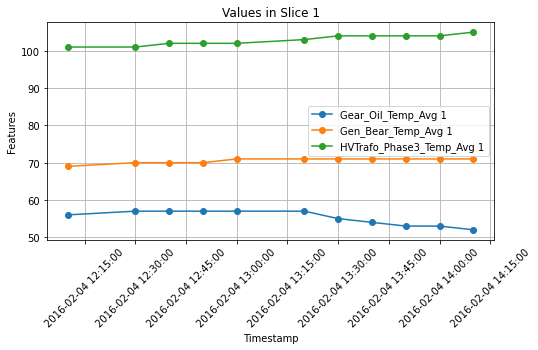

1
Slice 11 (Rows: 9):
Timestamp
2016-04-29 18:10:00+00:00    111.0
2016-04-29 18:20:00+00:00    114.0
2016-04-29 18:30:00+00:00    133.0
2016-04-29 18:40:00+00:00    156.0
2016-04-29 18:50:00+00:00    164.0
2016-04-29 19:00:00+00:00    138.0
2016-04-29 19:10:00+00:00    118.0
2016-04-29 19:20:00+00:00     95.0
2016-04-29 19:30:00+00:00     78.0
Name: Gen_Bear_Temp_Avg, dtype: float64



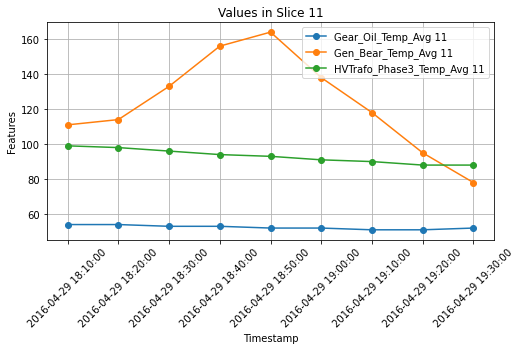

2
Slice 23 (Rows: 62):
Timestamp
2016-05-03 11:10:00+00:00    71.0
2016-05-03 11:20:00+00:00    72.0
2016-05-03 11:30:00+00:00    72.0
2016-05-03 11:40:00+00:00    72.0
2016-05-03 11:50:00+00:00    73.0
                             ... 
2016-05-03 20:50:00+00:00    75.0
2016-05-03 21:00:00+00:00    75.0
2016-05-03 21:10:00+00:00    74.0
2016-05-03 21:20:00+00:00    74.0
2016-05-03 21:30:00+00:00    74.0
Name: Gen_Bear_Temp_Avg, Length: 62, dtype: float64



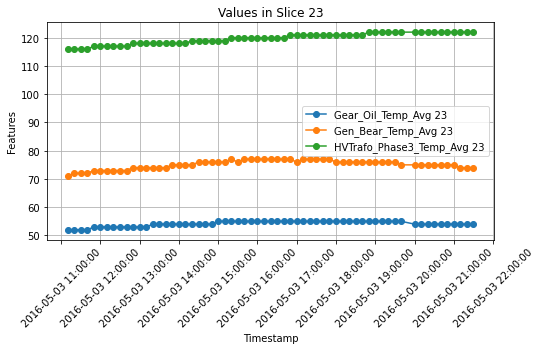

3
Slice 24 (Rows: 14):
Timestamp
2016-05-04 14:10:00+00:00    73.0
2016-05-04 14:20:00+00:00    72.0
2016-05-04 14:30:00+00:00    73.0
2016-05-04 14:40:00+00:00    73.0
2016-05-04 14:50:00+00:00    73.0
2016-05-04 15:00:00+00:00    73.0
2016-05-04 15:10:00+00:00    73.0
2016-05-04 15:20:00+00:00    73.0
2016-05-04 15:30:00+00:00    74.0
2016-05-04 15:40:00+00:00    74.0
2016-05-04 15:50:00+00:00    74.0
2016-05-04 16:00:00+00:00    74.0
2016-05-04 16:10:00+00:00    74.0
2016-05-04 16:20:00+00:00    74.0
Name: Gen_Bear_Temp_Avg, dtype: float64



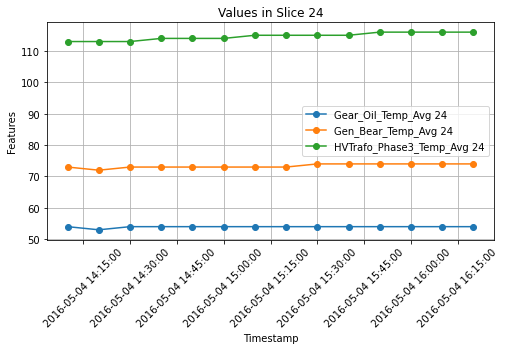

4
Slice 26 (Rows: 98):
Timestamp
2016-06-07 14:10:00+00:00    73.0
2016-06-07 14:20:00+00:00    74.0
2016-06-07 14:30:00+00:00    75.0
2016-06-07 14:40:00+00:00    75.0
2016-06-07 14:50:00+00:00    76.0
                             ... 
2016-06-08 05:40:00+00:00    76.0
2016-06-08 05:50:00+00:00    75.0
2016-06-08 06:00:00+00:00    75.0
2016-06-08 06:10:00+00:00    75.0
2016-06-08 06:20:00+00:00    75.0
Name: Gen_Bear_Temp_Avg, Length: 98, dtype: float64



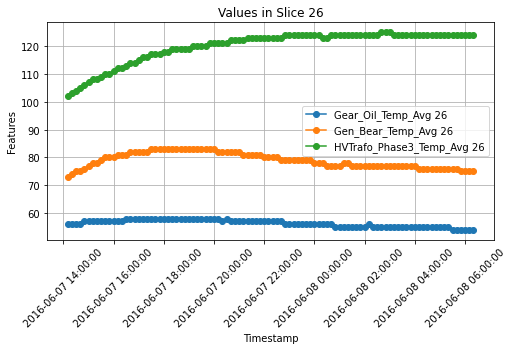

5
Slice 28 (Rows: 53):
Timestamp
2016-06-21 12:30:00+00:00    72.0
2016-06-21 12:40:00+00:00    73.0
2016-06-21 12:50:00+00:00    73.0
2016-06-21 13:00:00+00:00    74.0
2016-06-21 13:10:00+00:00    75.0
2016-06-21 13:20:00+00:00    75.0
2016-06-21 13:30:00+00:00    76.0
2016-06-21 13:40:00+00:00    76.0
2016-06-21 13:50:00+00:00    76.0
2016-06-21 14:00:00+00:00    77.0
2016-06-21 14:10:00+00:00    77.0
2016-06-21 14:20:00+00:00    77.0
2016-06-21 14:30:00+00:00    78.0
2016-06-21 14:40:00+00:00    78.0
2016-06-21 14:50:00+00:00    78.0
2016-06-21 15:00:00+00:00    79.0
2016-06-21 15:10:00+00:00    79.0
2016-06-21 15:20:00+00:00    79.0
2016-06-21 15:30:00+00:00    79.0
2016-06-21 15:40:00+00:00    79.0
2016-06-21 15:50:00+00:00    79.0
2016-06-21 16:00:00+00:00    79.0
2016-06-21 16:10:00+00:00    79.0
2016-06-21 16:20:00+00:00    79.0
2016-06-21 16:30:00+00:00    80.0
2016-06-21 16:40:00+00:00    80.0
2016-06-21 16:50:00+00:00    80.0
2016-06-21 17:00:00+00:00    80.0
2016-06-21 17:1

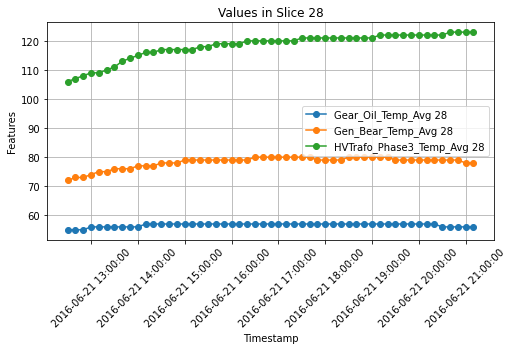

6
Slice 31 (Rows: 37):
Timestamp
2016-06-22 11:20:00+00:00    74.0
2016-06-22 11:30:00+00:00    74.0
2016-06-22 11:40:00+00:00    75.0
2016-06-22 11:50:00+00:00    75.0
2016-06-22 12:00:00+00:00    75.0
2016-06-22 12:10:00+00:00    75.0
2016-06-22 12:20:00+00:00    76.0
2016-06-22 12:30:00+00:00    76.0
2016-06-22 12:40:00+00:00    76.0
2016-06-22 12:50:00+00:00    76.0
2016-06-22 13:00:00+00:00    77.0
2016-06-22 13:10:00+00:00    77.0
2016-06-22 13:20:00+00:00    77.0
2016-06-22 13:30:00+00:00    77.0
2016-06-22 13:40:00+00:00    77.0
2016-06-22 13:50:00+00:00    77.0
2016-06-22 14:00:00+00:00    77.0
2016-06-22 14:10:00+00:00    77.0
2016-06-22 14:20:00+00:00    78.0
2016-06-22 14:30:00+00:00    78.0
2016-06-22 14:40:00+00:00    78.0
2016-06-22 14:50:00+00:00    78.0
2016-06-22 15:00:00+00:00    78.0
2016-06-22 15:10:00+00:00    78.0
2016-06-22 15:20:00+00:00    78.0
2016-06-22 15:30:00+00:00    78.0
2016-06-22 15:40:00+00:00    78.0
2016-06-22 15:50:00+00:00    78.0
2016-06-22 16:0

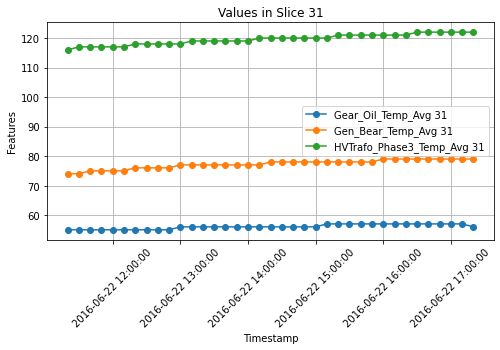

7
Slice 33 (Rows: 41):
Timestamp
2016-06-27 14:50:00+00:00    74.0
2016-06-27 15:00:00+00:00    75.0
2016-06-27 15:10:00+00:00    75.0
2016-06-27 15:20:00+00:00    76.0
2016-06-27 15:30:00+00:00    76.0
2016-06-27 15:40:00+00:00    77.0
2016-06-27 15:50:00+00:00    77.0
2016-06-27 16:00:00+00:00    77.0
2016-06-27 16:10:00+00:00    77.0
2016-06-27 16:20:00+00:00    77.0
2016-06-27 16:30:00+00:00    78.0
2016-06-27 16:40:00+00:00    78.0
2016-06-27 16:50:00+00:00    78.0
2016-06-27 17:00:00+00:00    78.0
2016-06-27 17:10:00+00:00    78.0
2016-06-27 17:20:00+00:00    79.0
2016-06-27 17:30:00+00:00    78.0
2016-06-27 17:40:00+00:00    79.0
2016-06-27 17:50:00+00:00    79.0
2016-06-27 18:00:00+00:00    79.0
2016-06-27 18:10:00+00:00    79.0
2016-06-27 18:20:00+00:00    79.0
2016-06-27 18:30:00+00:00    79.0
2016-06-27 18:40:00+00:00    79.0
2016-06-27 18:50:00+00:00    79.0
2016-06-27 19:00:00+00:00    79.0
2016-06-27 19:10:00+00:00    79.0
2016-06-27 19:20:00+00:00    79.0
2016-06-27 19:3

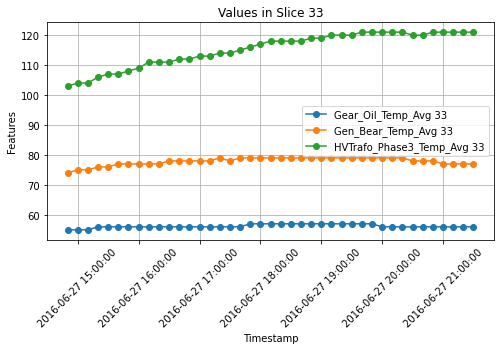

8
Slice 35 (Rows: 8):
Timestamp
2016-06-28 00:30:00+00:00    72.0
2016-06-28 00:40:00+00:00    72.0
2016-06-28 01:00:00+00:00    74.0
2016-06-28 01:10:00+00:00    74.0
2016-06-28 01:20:00+00:00    74.0
2016-06-28 01:30:00+00:00    75.0
2016-06-28 01:40:00+00:00    75.0
2016-06-28 01:50:00+00:00    75.0
Name: Gen_Bear_Temp_Avg, dtype: float64



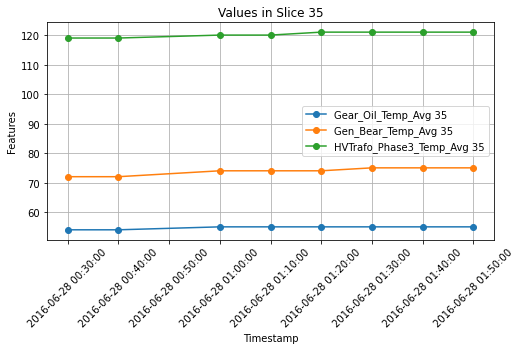

9
Slice 36 (Rows: 8):
Timestamp
2016-06-28 03:00:00+00:00    73.0
2016-06-28 03:10:00+00:00    73.0
2016-06-28 03:20:00+00:00    73.0
2016-06-28 03:30:00+00:00    74.0
2016-06-28 03:40:00+00:00    74.0
2016-06-28 03:50:00+00:00    74.0
2016-06-28 04:00:00+00:00    75.0
2016-06-28 04:10:00+00:00    75.0
Name: Gen_Bear_Temp_Avg, dtype: float64



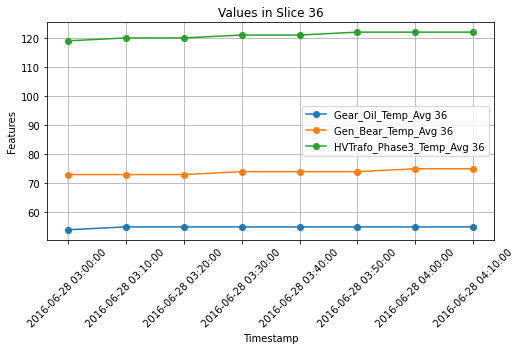

10
Slice 37 (Rows: 52):
Timestamp
2016-07-03 14:30:00+00:00    74.0
2016-07-03 14:40:00+00:00    75.0
2016-07-03 14:50:00+00:00    76.0
2016-07-03 15:00:00+00:00    77.0
2016-07-03 15:10:00+00:00    77.0
2016-07-03 15:20:00+00:00    78.0
2016-07-03 15:30:00+00:00    79.0
2016-07-03 15:40:00+00:00    79.0
2016-07-03 15:50:00+00:00    80.0
2016-07-03 16:00:00+00:00    80.0
2016-07-03 16:10:00+00:00    81.0
2016-07-03 16:20:00+00:00    81.0
2016-07-03 16:30:00+00:00    81.0
2016-07-03 16:40:00+00:00    82.0
2016-07-03 16:50:00+00:00    82.0
2016-07-03 17:00:00+00:00    81.0
2016-07-03 17:10:00+00:00    81.0
2016-07-03 17:20:00+00:00    81.0
2016-07-03 17:30:00+00:00    81.0
2016-07-03 17:40:00+00:00    82.0
2016-07-03 17:50:00+00:00    82.0
2016-07-03 18:00:00+00:00    82.0
2016-07-03 18:10:00+00:00    83.0
2016-07-03 18:20:00+00:00    83.0
2016-07-03 18:30:00+00:00    83.0
2016-07-03 18:40:00+00:00    83.0
2016-07-03 18:50:00+00:00    83.0
2016-07-03 19:00:00+00:00    84.0
2016-07-03 19:

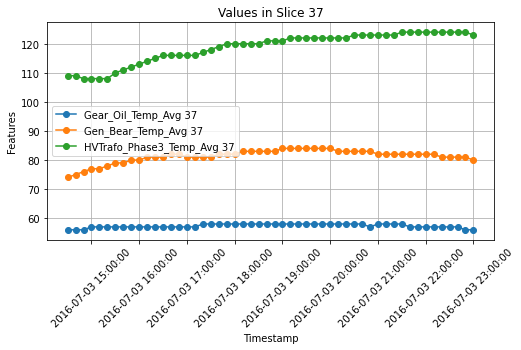

11
Slice 38 (Rows: 68):
Timestamp
2016-07-09 12:00:00+00:00    70.0
2016-07-09 12:10:00+00:00    71.0
2016-07-09 12:20:00+00:00    73.0
2016-07-09 12:30:00+00:00    74.0
2016-07-09 12:40:00+00:00    75.0
                             ... 
2016-07-09 22:40:00+00:00    78.0
2016-07-09 22:50:00+00:00    78.0
2016-07-09 23:00:00+00:00    79.0
2016-07-09 23:10:00+00:00    79.0
2016-07-09 23:20:00+00:00    79.0
Name: Gen_Bear_Temp_Avg, Length: 68, dtype: float64



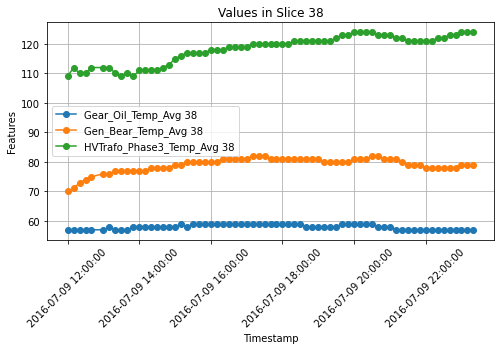

12
Slice 39 (Rows: 26):
Timestamp
2016-07-10 01:20:00+00:00    72.0
2016-07-10 01:40:00+00:00    73.0
2016-07-10 01:50:00+00:00    74.0
2016-07-10 02:00:00+00:00    74.0
2016-07-10 02:10:00+00:00    75.0
2016-07-10 02:20:00+00:00    75.0
2016-07-10 02:30:00+00:00    76.0
2016-07-10 02:40:00+00:00    76.0
2016-07-10 02:50:00+00:00    77.0
2016-07-10 03:00:00+00:00    78.0
2016-07-10 03:10:00+00:00    78.0
2016-07-10 03:20:00+00:00    78.0
2016-07-10 03:30:00+00:00    79.0
2016-07-10 03:40:00+00:00    79.0
2016-07-10 03:50:00+00:00    79.0
2016-07-10 04:00:00+00:00    79.0
2016-07-10 04:10:00+00:00    78.0
2016-07-10 04:20:00+00:00    76.0
2016-07-10 04:30:00+00:00    73.0
2016-07-10 04:40:00+00:00    70.0
2016-07-10 04:50:00+00:00    67.0
2016-07-10 05:00:00+00:00    64.0
2016-07-10 05:10:00+00:00    61.0
2016-07-10 05:20:00+00:00    58.0
2016-07-10 05:30:00+00:00    56.0
2016-07-10 05:40:00+00:00    54.0
Name: Gen_Bear_Temp_Avg, dtype: float64



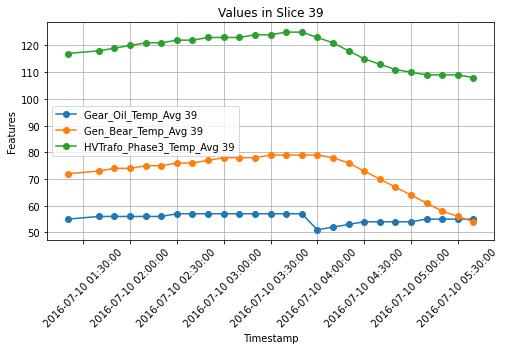

13
Slice 40 (Rows: 15):
Timestamp
2016-07-14 05:30:00+00:00    74.0
2016-07-14 05:40:00+00:00    74.0
2016-07-14 05:50:00+00:00    74.0
2016-07-14 06:00:00+00:00    75.0
2016-07-14 06:10:00+00:00    75.0
2016-07-14 06:20:00+00:00    75.0
2016-07-14 06:30:00+00:00    76.0
2016-07-14 06:40:00+00:00    76.0
2016-07-14 06:50:00+00:00    76.0
2016-07-14 07:10:00+00:00    76.0
2016-07-14 07:20:00+00:00    77.0
2016-07-14 07:30:00+00:00    77.0
2016-07-14 07:40:00+00:00    77.0
2016-07-14 07:50:00+00:00    76.0
2016-07-14 08:00:00+00:00    76.0
Name: Gen_Bear_Temp_Avg, dtype: float64



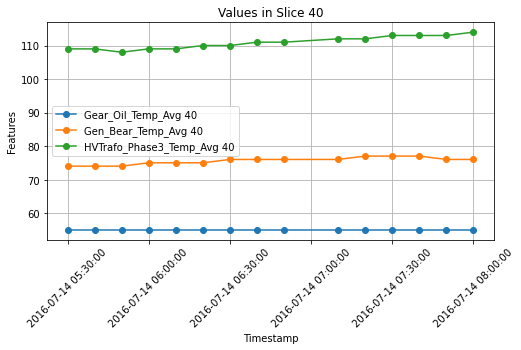

14
Slice 41 (Rows: 89):
Timestamp
2016-07-14 09:30:00+00:00    75.0
2016-07-14 09:40:00+00:00    76.0
2016-07-14 09:50:00+00:00    76.0
2016-07-14 10:00:00+00:00    76.0
2016-07-14 10:10:00+00:00    76.0
                             ... 
2016-07-14 23:30:00+00:00    61.0
2016-07-14 23:40:00+00:00    59.0
2016-07-14 23:50:00+00:00    56.0
2016-07-15 00:00:00+00:00    54.0
2016-07-15 00:10:00+00:00    51.0
Name: Gen_Bear_Temp_Avg, Length: 89, dtype: float64



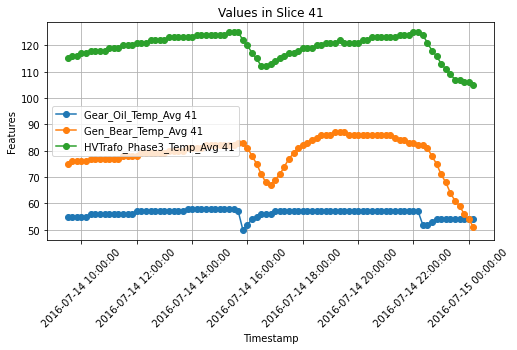

15
Slice 44 (Rows: 40):
Timestamp
2016-07-15 09:20:00+00:00    72.0
2016-07-15 09:30:00+00:00    73.0
2016-07-15 09:40:00+00:00    73.0
2016-07-15 09:50:00+00:00    73.0
2016-07-15 10:00:00+00:00    74.0
2016-07-15 10:10:00+00:00    74.0
2016-07-15 10:20:00+00:00    75.0
2016-07-15 10:30:00+00:00    75.0
2016-07-15 10:40:00+00:00    76.0
2016-07-15 10:50:00+00:00    76.0
2016-07-15 11:00:00+00:00    77.0
2016-07-15 11:10:00+00:00    77.0
2016-07-15 11:20:00+00:00    77.0
2016-07-15 11:30:00+00:00    78.0
2016-07-15 11:40:00+00:00    78.0
2016-07-15 11:50:00+00:00    78.0
2016-07-15 12:00:00+00:00    78.0
2016-07-15 12:10:00+00:00    79.0
2016-07-15 12:20:00+00:00    79.0
2016-07-15 12:30:00+00:00    79.0
2016-07-15 12:40:00+00:00    80.0
2016-07-15 12:50:00+00:00    80.0
2016-07-15 13:00:00+00:00    80.0
2016-07-15 13:10:00+00:00    80.0
2016-07-15 13:20:00+00:00    80.0
2016-07-15 13:30:00+00:00    80.0
2016-07-15 13:40:00+00:00    80.0
2016-07-15 13:50:00+00:00    80.0
2016-07-15 14:

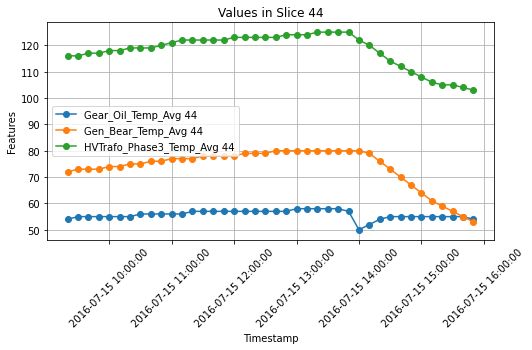

16
Slice 47 (Rows: 163):
Timestamp
2016-07-16 01:10:00+00:00    70.0
2016-07-16 01:20:00+00:00    71.0
2016-07-16 01:30:00+00:00    72.0
2016-07-16 01:40:00+00:00    72.0
2016-07-16 01:50:00+00:00    73.0
                             ... 
2016-07-17 03:40:00+00:00    66.0
2016-07-17 03:50:00+00:00    68.0
2016-07-17 04:00:00+00:00    67.0
2016-07-17 04:10:00+00:00    66.0
2016-07-17 04:20:00+00:00    63.0
Name: Gen_Bear_Temp_Avg, Length: 163, dtype: float64



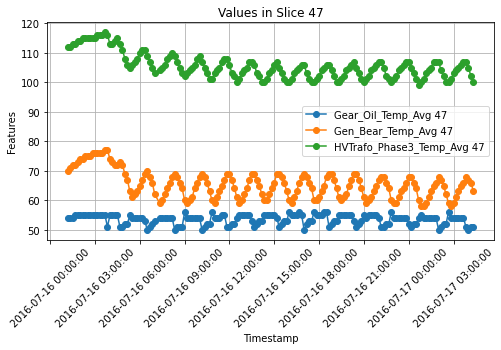

17
Slice 48 (Rows: 30):
Timestamp
2016-07-17 05:10:00+00:00    62.0
2016-07-17 05:20:00+00:00    64.0
2016-07-17 05:30:00+00:00    66.0
2016-07-17 05:40:00+00:00    68.0
2016-07-17 05:50:00+00:00    68.0
2016-07-17 06:00:00+00:00    67.0
2016-07-17 06:10:00+00:00    64.0
2016-07-17 06:20:00+00:00    60.0
2016-07-17 06:30:00+00:00    58.0
2016-07-17 06:40:00+00:00    59.0
2016-07-17 06:50:00+00:00    60.0
2016-07-17 07:00:00+00:00    62.0
2016-07-17 07:10:00+00:00    64.0
2016-07-17 07:20:00+00:00    65.0
2016-07-17 07:30:00+00:00    67.0
2016-07-17 07:40:00+00:00    68.0
2016-07-17 07:50:00+00:00    67.0
2016-07-17 08:00:00+00:00    65.0
2016-07-17 08:10:00+00:00    62.0
2016-07-17 08:20:00+00:00    59.0
2016-07-17 08:30:00+00:00    58.0
2016-07-17 08:40:00+00:00    60.0
2016-07-17 08:50:00+00:00    61.0
2016-07-17 09:00:00+00:00    63.0
2016-07-17 09:10:00+00:00    65.0
2016-07-17 09:20:00+00:00    66.0
2016-07-17 09:30:00+00:00    68.0
2016-07-17 09:40:00+00:00    67.0
2016-07-17 09:

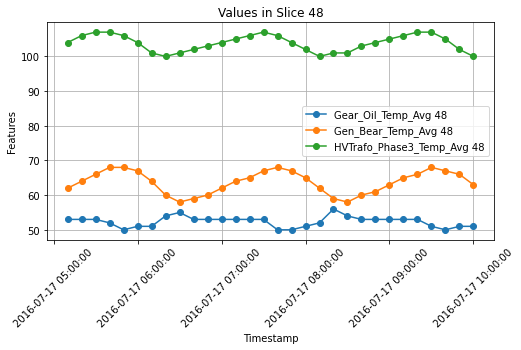

18
Slice 49 (Rows: 70):
Timestamp
2016-07-17 10:30:00+00:00    59.0
2016-07-17 10:40:00+00:00    61.0
2016-07-17 10:50:00+00:00    63.0
2016-07-17 11:00:00+00:00    65.0
2016-07-17 11:10:00+00:00    66.0
                             ... 
2016-07-17 21:30:00+00:00    68.0
2016-07-17 21:40:00+00:00    69.0
2016-07-17 21:50:00+00:00    68.0
2016-07-17 22:00:00+00:00    66.0
2016-07-17 22:10:00+00:00    64.0
Name: Gen_Bear_Temp_Avg, Length: 70, dtype: float64



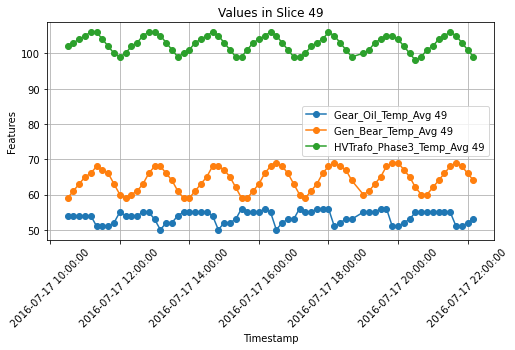

19
Slice 50 (Rows: 8):
Timestamp
2016-07-17 23:20:00+00:00    64.0
2016-07-17 23:30:00+00:00    66.0
2016-07-17 23:40:00+00:00    67.0
2016-07-17 23:50:00+00:00    69.0
2016-07-18 00:00:00+00:00    70.0
2016-07-18 00:10:00+00:00    69.0
2016-07-18 00:20:00+00:00    68.0
2016-07-18 00:30:00+00:00    65.0
Name: Gen_Bear_Temp_Avg, dtype: float64



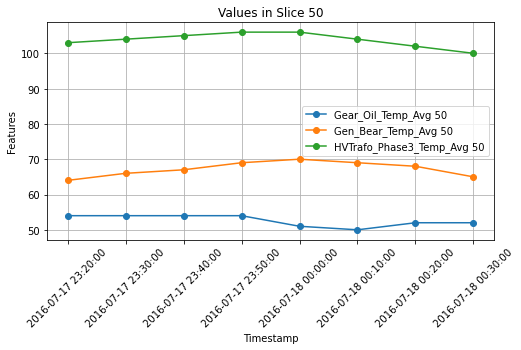

20
Slice 51 (Rows: 9):
Timestamp
2016-07-18 01:00:00+00:00    61.0
2016-07-18 01:10:00+00:00    62.0
2016-07-18 01:20:00+00:00    64.0
2016-07-18 01:30:00+00:00    66.0
2016-07-18 01:40:00+00:00    68.0
2016-07-18 01:50:00+00:00    69.0
2016-07-18 02:00:00+00:00    67.0
2016-07-18 02:10:00+00:00    65.0
2016-07-18 02:20:00+00:00    62.0
Name: Gen_Bear_Temp_Avg, dtype: float64



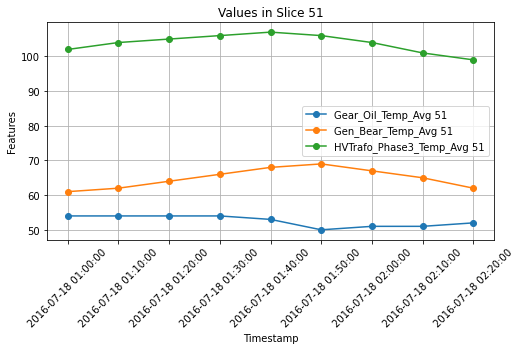

21
Slice 52 (Rows: 9):
Timestamp
2016-07-18 02:50:00+00:00    60.0
2016-07-18 03:00:00+00:00    61.0
2016-07-18 03:10:00+00:00    63.0
2016-07-18 03:20:00+00:00    65.0
2016-07-18 03:30:00+00:00    67.0
2016-07-18 03:40:00+00:00    68.0
2016-07-18 03:50:00+00:00    67.0
2016-07-18 04:00:00+00:00    65.0
2016-07-18 04:10:00+00:00    62.0
Name: Gen_Bear_Temp_Avg, dtype: float64



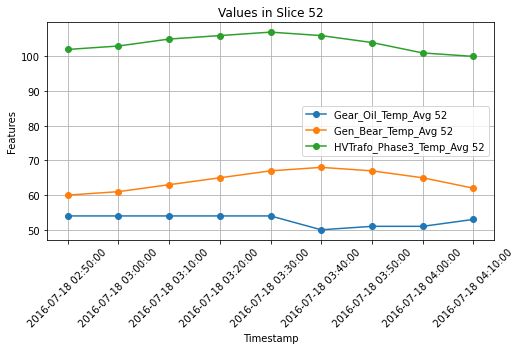

22
Slice 53 (Rows: 8):
Timestamp
2016-07-18 04:50:00+00:00    62.0
2016-07-18 05:00:00+00:00    63.0
2016-07-18 05:10:00+00:00    65.0
2016-07-18 05:20:00+00:00    67.0
2016-07-18 05:30:00+00:00    68.0
2016-07-18 05:40:00+00:00    67.0
2016-07-18 05:50:00+00:00    65.0
2016-07-18 06:00:00+00:00    62.0
Name: Gen_Bear_Temp_Avg, dtype: float64



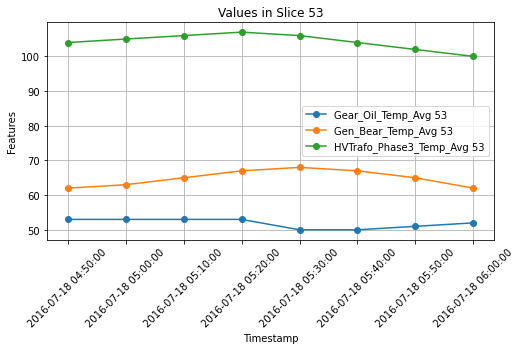

23
Slice 55 (Rows: 14):
Timestamp
2016-07-18 09:50:00+00:00    66.0
2016-07-18 10:00:00+00:00    67.0
2016-07-18 10:10:00+00:00    68.0
2016-07-18 10:20:00+00:00    66.0
2016-07-18 10:30:00+00:00    65.0
2016-07-18 10:40:00+00:00    65.0
2016-07-18 10:50:00+00:00    66.0
2016-07-18 11:00:00+00:00    65.0
2016-07-18 11:10:00+00:00    63.0
2016-07-18 11:20:00+00:00    61.0
2016-07-18 11:30:00+00:00    59.0
2016-07-18 11:40:00+00:00    59.0
2016-07-18 11:50:00+00:00    60.0
2016-07-18 12:00:00+00:00    60.0
Name: Gen_Bear_Temp_Avg, dtype: float64



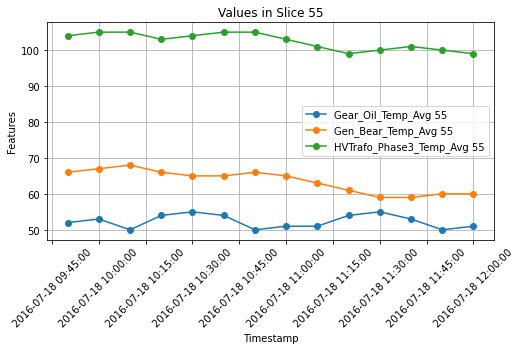

24
Slice 57 (Rows: 25):
Timestamp
2016-07-18 15:50:00+00:00    71.0
2016-07-18 16:00:00+00:00    72.0
2016-07-18 16:10:00+00:00    74.0
2016-07-18 16:20:00+00:00    75.0
2016-07-18 16:30:00+00:00    76.0
2016-07-18 16:40:00+00:00    76.0
2016-07-18 16:50:00+00:00    77.0
2016-07-18 17:00:00+00:00    78.0
2016-07-18 17:10:00+00:00    78.0
2016-07-18 17:20:00+00:00    79.0
2016-07-18 17:30:00+00:00    79.0
2016-07-18 17:40:00+00:00    80.0
2016-07-18 17:50:00+00:00    80.0
2016-07-18 18:00:00+00:00    81.0
2016-07-18 18:10:00+00:00    81.0
2016-07-18 18:20:00+00:00    81.0
2016-07-18 18:30:00+00:00    82.0
2016-07-18 18:40:00+00:00    81.0
2016-07-18 18:50:00+00:00    81.0
2016-07-18 19:00:00+00:00    81.0
2016-07-18 19:10:00+00:00    81.0
2016-07-18 19:20:00+00:00    81.0
2016-07-18 19:30:00+00:00    81.0
2016-07-18 19:40:00+00:00    81.0
2016-07-18 19:50:00+00:00    81.0
Name: Gen_Bear_Temp_Avg, dtype: float64



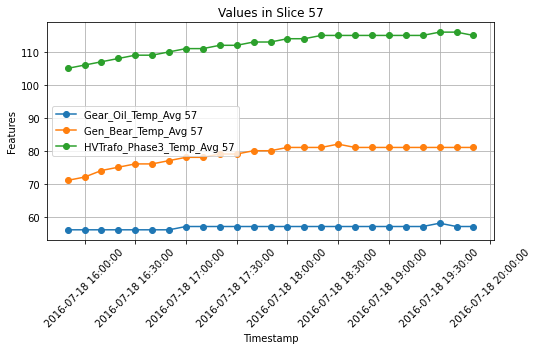

25
Slice 58 (Rows: 9):
Timestamp
2016-07-19 09:20:00+00:00    73.0
2016-07-19 09:30:00+00:00    74.0
2016-07-19 09:40:00+00:00    74.0
2016-07-19 09:50:00+00:00    75.0
2016-07-19 10:00:00+00:00    75.0
2016-07-19 10:10:00+00:00    75.0
2016-07-19 10:20:00+00:00    76.0
2016-07-19 10:30:00+00:00    76.0
2016-07-19 10:40:00+00:00    76.0
Name: Gen_Bear_Temp_Avg, dtype: float64



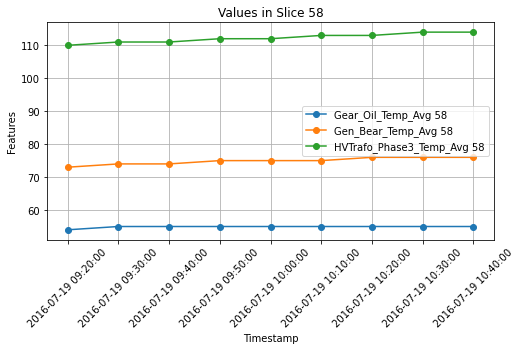

26
Slice 60 (Rows: 10):
Timestamp
2016-07-19 12:10:00+00:00    71.0
2016-07-19 12:20:00+00:00    72.0
2016-07-19 12:30:00+00:00    73.0
2016-07-19 12:40:00+00:00    74.0
2016-07-19 12:50:00+00:00    75.0
2016-07-19 13:00:00+00:00    75.0
2016-07-19 13:10:00+00:00    76.0
2016-07-19 13:20:00+00:00    77.0
2016-07-19 13:30:00+00:00    77.0
2016-07-19 13:40:00+00:00    78.0
Name: Gen_Bear_Temp_Avg, dtype: float64



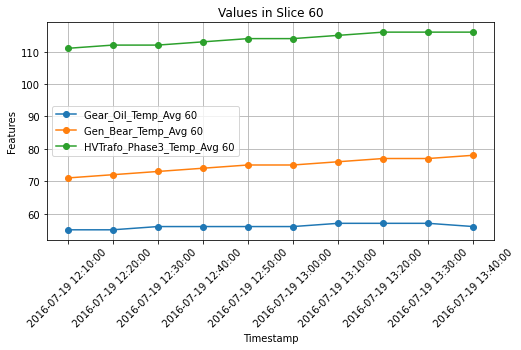

27
Slice 67 (Rows: 8):
Timestamp
2016-07-24 06:10:00+00:00    74.0
2016-07-24 06:20:00+00:00    74.0
2016-07-24 06:30:00+00:00    74.0
2016-07-24 06:40:00+00:00    75.0
2016-07-24 06:50:00+00:00    75.0
2016-07-24 07:00:00+00:00    75.0
2016-07-24 07:10:00+00:00    75.0
2016-07-24 07:20:00+00:00    75.0
Name: Gen_Bear_Temp_Avg, dtype: float64



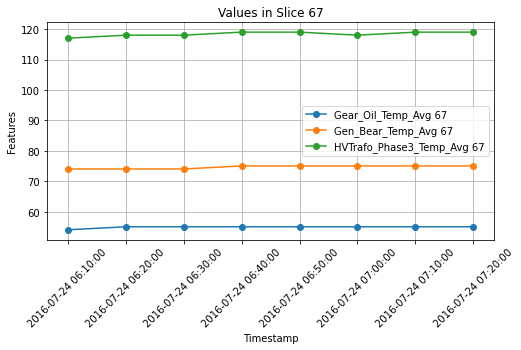

28
Slice 68 (Rows: 34):
Timestamp
2016-07-24 09:50:00+00:00    75.0
2016-07-24 10:00:00+00:00    75.0
2016-07-24 10:10:00+00:00    75.0
2016-07-24 10:20:00+00:00    75.0
2016-07-24 10:40:00+00:00    76.0
2016-07-24 10:50:00+00:00    76.0
2016-07-24 11:00:00+00:00    76.0
2016-07-24 11:10:00+00:00    76.0
2016-07-24 11:20:00+00:00    76.0
2016-07-24 11:30:00+00:00    77.0
2016-07-24 11:40:00+00:00    77.0
2016-07-24 11:50:00+00:00    77.0
2016-07-24 12:00:00+00:00    77.0
2016-07-24 12:10:00+00:00    77.0
2016-07-24 12:20:00+00:00    77.0
2016-07-24 12:30:00+00:00    78.0
2016-07-24 12:40:00+00:00    78.0
2016-07-24 12:50:00+00:00    78.0
2016-07-24 13:00:00+00:00    79.0
2016-07-24 13:10:00+00:00    79.0
2016-07-24 13:20:00+00:00    79.0
2016-07-24 13:30:00+00:00    80.0
2016-07-24 13:40:00+00:00    79.0
2016-07-24 13:50:00+00:00    77.0
2016-07-24 14:00:00+00:00    74.0
2016-07-24 14:10:00+00:00    71.0
2016-07-24 14:20:00+00:00    68.0
2016-07-24 14:30:00+00:00    66.0
2016-07-24 14:

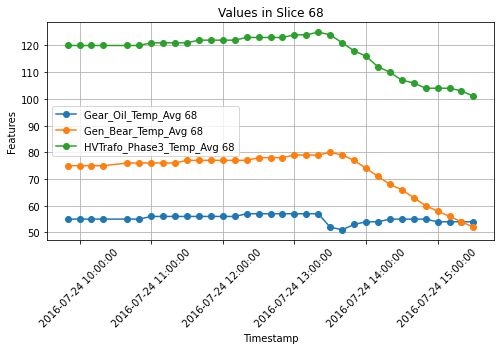

29
Slice 70 (Rows: 27):
Timestamp
2016-07-24 20:50:00+00:00    65.0
2016-07-24 21:00:00+00:00    67.0
2016-07-24 21:10:00+00:00    69.0
2016-07-24 21:20:00+00:00    70.0
2016-07-24 21:30:00+00:00    71.0
2016-07-24 21:40:00+00:00    72.0
2016-07-24 21:50:00+00:00    72.0
2016-07-24 22:00:00+00:00    73.0
2016-07-24 22:10:00+00:00    73.0
2016-07-24 22:20:00+00:00    74.0
2016-07-24 22:30:00+00:00    74.0
2016-07-24 22:40:00+00:00    75.0
2016-07-24 22:50:00+00:00    75.0
2016-07-24 23:00:00+00:00    75.0
2016-07-24 23:10:00+00:00    76.0
2016-07-24 23:20:00+00:00    76.0
2016-07-24 23:30:00+00:00    76.0
2016-07-24 23:40:00+00:00    76.0
2016-07-24 23:50:00+00:00    76.0
2016-07-25 00:00:00+00:00    76.0
2016-07-25 00:10:00+00:00    76.0
2016-07-25 00:20:00+00:00    76.0
2016-07-25 00:30:00+00:00    76.0
2016-07-25 00:40:00+00:00    77.0
2016-07-25 00:50:00+00:00    77.0
2016-07-25 01:00:00+00:00    77.0
2016-07-25 01:10:00+00:00    77.0
Name: Gen_Bear_Temp_Avg, dtype: float64



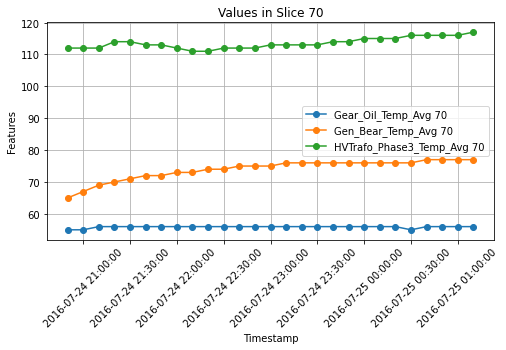

30
Slice 71 (Rows: 73):
Timestamp
2016-07-25 10:30:00+00:00    71.0
2016-07-25 10:40:00+00:00    72.0
2016-07-25 10:50:00+00:00    73.0
2016-07-25 11:00:00+00:00    74.0
2016-07-25 11:10:00+00:00    74.0
                             ... 
2016-07-25 21:50:00+00:00    62.0
2016-07-25 22:00:00+00:00    59.0
2016-07-25 22:10:00+00:00    57.0
2016-07-25 22:20:00+00:00    55.0
2016-07-25 22:30:00+00:00    53.0
Name: Gen_Bear_Temp_Avg, Length: 73, dtype: float64



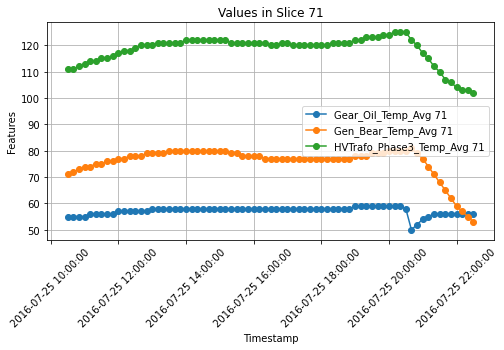

31
Slice 74 (Rows: 12):
Timestamp
2016-07-26 13:00:00+00:00    73.0
2016-07-26 13:10:00+00:00    74.0
2016-07-26 13:20:00+00:00    75.0
2016-07-26 13:30:00+00:00    75.0
2016-07-26 13:40:00+00:00    76.0
2016-07-26 13:50:00+00:00    77.0
2016-07-26 14:00:00+00:00    78.0
2016-07-26 14:10:00+00:00    78.0
2016-07-26 14:20:00+00:00    79.0
2016-07-26 14:30:00+00:00    79.0
2016-07-26 14:40:00+00:00    80.0
2016-07-26 14:50:00+00:00    80.0
Name: Gen_Bear_Temp_Avg, dtype: float64



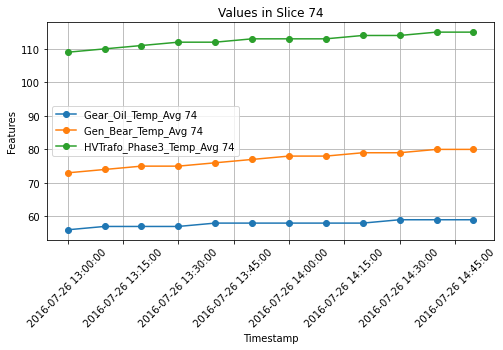

32
Slice 78 (Rows: 24):
Timestamp
2016-08-06 10:30:00+00:00    75.0
2016-08-06 10:50:00+00:00    75.0
2016-08-06 11:00:00+00:00    75.0
2016-08-06 11:10:00+00:00    76.0
2016-08-06 11:20:00+00:00    76.0
2016-08-06 11:30:00+00:00    76.0
2016-08-06 11:40:00+00:00    77.0
2016-08-06 11:50:00+00:00    77.0
2016-08-06 12:00:00+00:00    77.0
2016-08-06 12:10:00+00:00    78.0
2016-08-06 12:20:00+00:00    78.0
2016-08-06 12:30:00+00:00    78.0
2016-08-06 12:40:00+00:00    79.0
2016-08-06 12:50:00+00:00    79.0
2016-08-06 13:00:00+00:00    77.0
2016-08-06 13:10:00+00:00    74.0
2016-08-06 13:20:00+00:00    71.0
2016-08-06 13:30:00+00:00    68.0
2016-08-06 13:40:00+00:00    66.0
2016-08-06 13:50:00+00:00    63.0
2016-08-06 14:00:00+00:00    60.0
2016-08-06 14:20:00+00:00    56.0
2016-08-06 14:30:00+00:00    54.0
2016-08-06 14:40:00+00:00    52.0
Name: Gen_Bear_Temp_Avg, dtype: float64



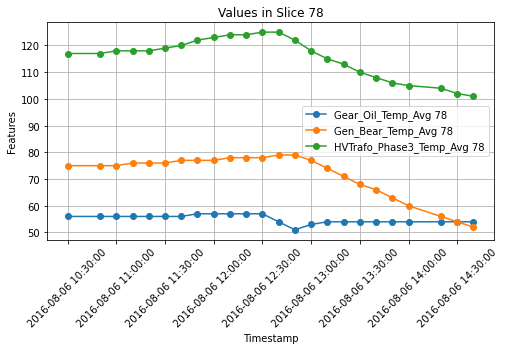

33
Slice 80 (Rows: 30):
Timestamp
2016-08-06 16:50:00+00:00    71.0
2016-08-06 17:00:00+00:00    73.0
2016-08-06 17:10:00+00:00    74.0
2016-08-06 17:20:00+00:00    76.0
2016-08-06 17:30:00+00:00    77.0
2016-08-06 17:40:00+00:00    77.0
2016-08-06 17:50:00+00:00    78.0
2016-08-06 18:00:00+00:00    79.0
2016-08-06 18:10:00+00:00    79.0
2016-08-06 18:20:00+00:00    79.0
2016-08-06 18:30:00+00:00    80.0
2016-08-06 18:40:00+00:00    80.0
2016-08-06 18:50:00+00:00    80.0
2016-08-06 19:00:00+00:00    79.0
2016-08-06 19:10:00+00:00    79.0
2016-08-06 19:20:00+00:00    79.0
2016-08-06 19:30:00+00:00    79.0
2016-08-06 19:40:00+00:00    79.0
2016-08-06 19:50:00+00:00    79.0
2016-08-06 20:00:00+00:00    79.0
2016-08-06 20:10:00+00:00    80.0
2016-08-06 20:20:00+00:00    80.0
2016-08-06 20:30:00+00:00    80.0
2016-08-06 20:40:00+00:00    80.0
2016-08-06 20:50:00+00:00    80.0
2016-08-06 21:00:00+00:00    80.0
2016-08-06 21:10:00+00:00    80.0
2016-08-06 21:20:00+00:00    80.0
2016-08-06 21:

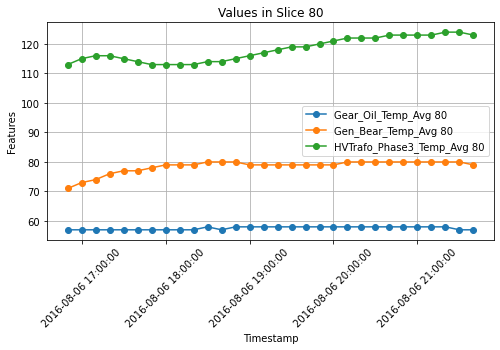

34
Slice 82 (Rows: 80):
Timestamp
2016-08-07 11:40:00+00:00    73.0
2016-08-07 11:50:00+00:00    74.0
2016-08-07 12:00:00+00:00    74.0
2016-08-07 12:10:00+00:00    75.0
2016-08-07 12:20:00+00:00    75.0
                             ... 
2016-08-08 00:20:00+00:00    77.0
2016-08-08 00:30:00+00:00    77.0
2016-08-08 00:40:00+00:00    77.0
2016-08-08 00:50:00+00:00    77.0
2016-08-08 01:00:00+00:00    77.0
Name: Gen_Bear_Temp_Avg, Length: 80, dtype: float64



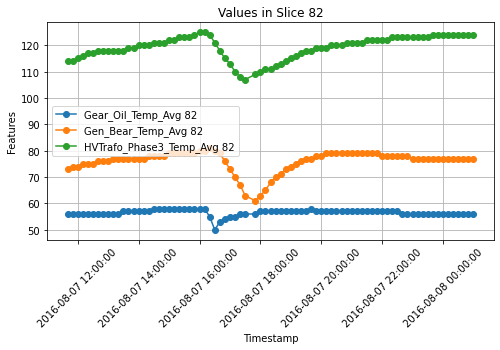

35
Slice 83 (Rows: 69):
Timestamp
2016-08-08 10:40:00+00:00    72.0
2016-08-08 11:00:00+00:00    73.0
2016-08-08 11:10:00+00:00    74.0
2016-08-08 11:20:00+00:00    74.0
2016-08-08 11:30:00+00:00    75.0
                             ... 
2016-08-08 21:40:00+00:00    80.0
2016-08-08 21:50:00+00:00    80.0
2016-08-08 22:00:00+00:00    79.0
2016-08-08 22:10:00+00:00    79.0
2016-08-08 22:20:00+00:00    79.0
Name: Gen_Bear_Temp_Avg, Length: 69, dtype: float64



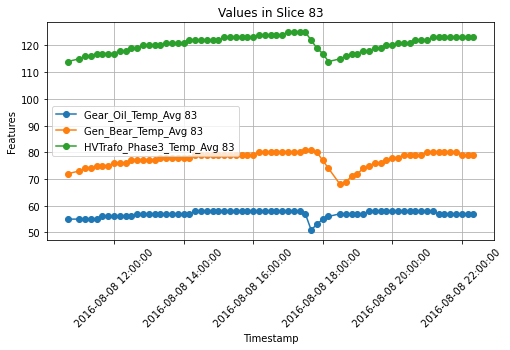

36
Slice 86 (Rows: 46):
Timestamp
2016-08-10 13:40:00+00:00    74.0
2016-08-10 13:50:00+00:00    75.0
2016-08-10 14:00:00+00:00    75.0
2016-08-10 14:10:00+00:00    76.0
2016-08-10 14:20:00+00:00    76.0
2016-08-10 14:30:00+00:00    77.0
2016-08-10 14:40:00+00:00    77.0
2016-08-10 14:50:00+00:00    78.0
2016-08-10 15:00:00+00:00    78.0
2016-08-10 15:10:00+00:00    78.0
2016-08-10 15:20:00+00:00    78.0
2016-08-10 15:30:00+00:00    79.0
2016-08-10 15:40:00+00:00    79.0
2016-08-10 15:50:00+00:00    79.0
2016-08-10 16:00:00+00:00    79.0
2016-08-10 16:10:00+00:00    79.0
2016-08-10 16:20:00+00:00    79.0
2016-08-10 16:30:00+00:00    80.0
2016-08-10 16:40:00+00:00    80.0
2016-08-10 16:50:00+00:00    80.0
2016-08-10 17:00:00+00:00    80.0
2016-08-10 17:10:00+00:00    80.0
2016-08-10 17:20:00+00:00    80.0
2016-08-10 17:30:00+00:00    80.0
2016-08-10 17:40:00+00:00    80.0
2016-08-10 17:50:00+00:00    81.0
2016-08-10 18:00:00+00:00    81.0
2016-08-10 18:10:00+00:00    80.0
2016-08-10 18:

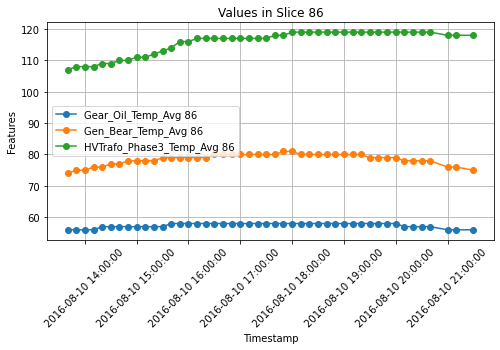

37
Slice 87 (Rows: 29):
Timestamp
2016-08-10 23:50:00+00:00    70.0
2016-08-11 00:10:00+00:00    72.0
2016-08-11 00:20:00+00:00    72.0
2016-08-11 00:30:00+00:00    73.0
2016-08-11 00:40:00+00:00    73.0
2016-08-11 00:50:00+00:00    73.0
2016-08-11 01:00:00+00:00    74.0
2016-08-11 01:10:00+00:00    74.0
2016-08-11 01:20:00+00:00    74.0
2016-08-11 01:30:00+00:00    75.0
2016-08-11 01:40:00+00:00    75.0
2016-08-11 01:50:00+00:00    75.0
2016-08-11 02:00:00+00:00    75.0
2016-08-11 02:10:00+00:00    75.0
2016-08-11 02:20:00+00:00    75.0
2016-08-11 02:30:00+00:00    76.0
2016-08-11 02:40:00+00:00    76.0
2016-08-11 02:50:00+00:00    76.0
2016-08-11 03:00:00+00:00    76.0
2016-08-11 03:10:00+00:00    76.0
2016-08-11 03:20:00+00:00    76.0
2016-08-11 03:30:00+00:00    76.0
2016-08-11 03:40:00+00:00    76.0
2016-08-11 03:50:00+00:00    76.0
2016-08-11 04:00:00+00:00    76.0
2016-08-11 04:10:00+00:00    76.0
2016-08-11 04:20:00+00:00    76.0
2016-08-11 04:30:00+00:00    76.0
2016-08-11 04:

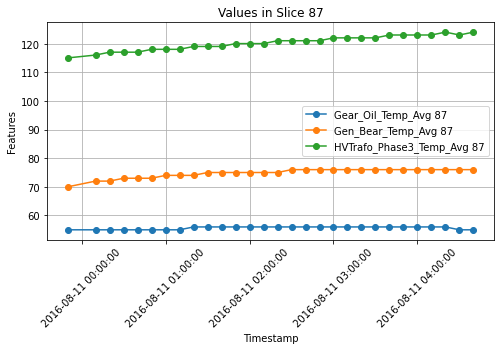

38
Slice 89 (Rows: 28):
Timestamp
2016-08-11 10:10:00+00:00    74.0
2016-08-11 10:30:00+00:00    75.0
2016-08-11 10:40:00+00:00    75.0
2016-08-11 10:50:00+00:00    75.0
2016-08-11 11:00:00+00:00    76.0
2016-08-11 11:10:00+00:00    76.0
2016-08-11 11:20:00+00:00    77.0
2016-08-11 11:30:00+00:00    77.0
2016-08-11 11:40:00+00:00    77.0
2016-08-11 11:50:00+00:00    77.0
2016-08-11 12:00:00+00:00    77.0
2016-08-11 12:10:00+00:00    78.0
2016-08-11 12:20:00+00:00    78.0
2016-08-11 12:30:00+00:00    78.0
2016-08-11 12:40:00+00:00    78.0
2016-08-11 12:50:00+00:00    79.0
2016-08-11 13:00:00+00:00    79.0
2016-08-11 13:10:00+00:00    77.0
2016-08-11 13:20:00+00:00    74.0
2016-08-11 13:30:00+00:00    71.0
2016-08-11 13:40:00+00:00    68.0
2016-08-11 13:50:00+00:00    65.0
2016-08-11 14:00:00+00:00    62.0
2016-08-11 14:10:00+00:00    59.0
2016-08-11 14:20:00+00:00    57.0
2016-08-11 14:30:00+00:00    55.0
2016-08-11 14:40:00+00:00    53.0
2016-08-11 14:50:00+00:00    51.0
Name: Gen_Bear

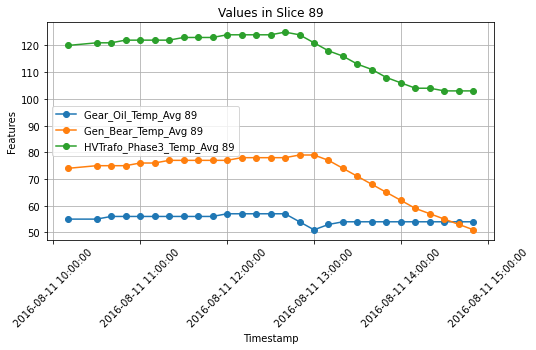

39
Slice 93 (Rows: 13):
Timestamp
2016-08-12 04:30:00+00:00    75.0
2016-08-12 04:40:00+00:00    75.0
2016-08-12 05:00:00+00:00    75.0
2016-08-12 05:10:00+00:00    75.0
2016-08-12 05:20:00+00:00    75.0
2016-08-12 05:30:00+00:00    76.0
2016-08-12 05:40:00+00:00    76.0
2016-08-12 05:50:00+00:00    76.0
2016-08-12 06:00:00+00:00    75.0
2016-08-12 06:10:00+00:00    76.0
2016-08-12 06:20:00+00:00    75.0
2016-08-12 06:30:00+00:00    76.0
2016-08-12 06:40:00+00:00    76.0
Name: Gen_Bear_Temp_Avg, dtype: float64



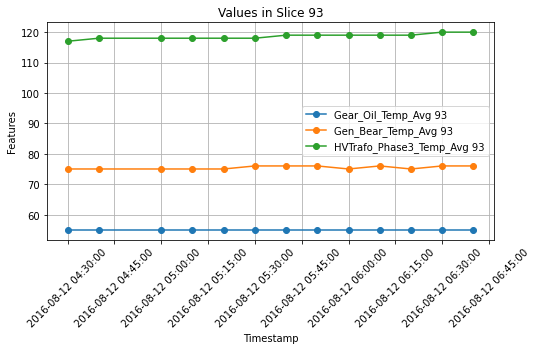

40
Slice 94 (Rows: 50):
Timestamp
2016-08-12 08:10:00+00:00    73.0
2016-08-12 08:30:00+00:00    74.0
2016-08-12 08:50:00+00:00    75.0
2016-08-12 09:00:00+00:00    75.0
2016-08-12 09:10:00+00:00    75.0
2016-08-12 09:20:00+00:00    75.0
2016-08-12 09:30:00+00:00    75.0
2016-08-12 09:40:00+00:00    75.0
2016-08-12 09:50:00+00:00    76.0
2016-08-12 10:00:00+00:00    76.0
2016-08-12 10:10:00+00:00    76.0
2016-08-12 10:20:00+00:00    76.0
2016-08-12 10:30:00+00:00    76.0
2016-08-12 10:40:00+00:00    76.0
2016-08-12 10:50:00+00:00    76.0
2016-08-12 11:00:00+00:00    77.0
2016-08-12 11:10:00+00:00    77.0
2016-08-12 11:20:00+00:00    77.0
2016-08-12 11:30:00+00:00    77.0
2016-08-12 11:40:00+00:00    77.0
2016-08-12 11:50:00+00:00    76.0
2016-08-12 12:00:00+00:00    76.0
2016-08-12 12:10:00+00:00    77.0
2016-08-12 12:20:00+00:00    77.0
2016-08-12 12:30:00+00:00    77.0
2016-08-12 12:40:00+00:00    77.0
2016-08-12 12:50:00+00:00    77.0
2016-08-12 13:00:00+00:00    77.0
2016-08-12 13:

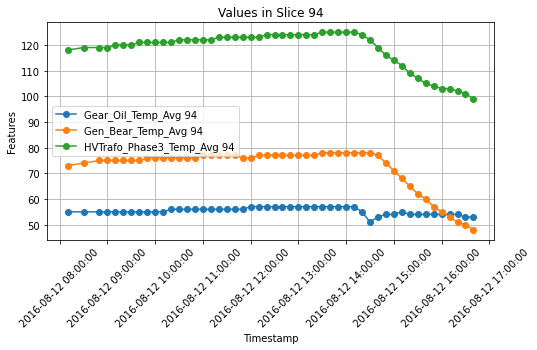

41
Slice 100 (Rows: 48):
Timestamp
2016-08-13 11:10:00+00:00    75.0
2016-08-13 11:20:00+00:00    75.0
2016-08-13 11:30:00+00:00    75.0
2016-08-13 11:40:00+00:00    75.0
2016-08-13 11:50:00+00:00    75.0
2016-08-13 12:00:00+00:00    76.0
2016-08-13 12:10:00+00:00    76.0
2016-08-13 12:20:00+00:00    76.0
2016-08-13 12:30:00+00:00    76.0
2016-08-13 12:40:00+00:00    76.0
2016-08-13 12:50:00+00:00    76.0
2016-08-13 13:00:00+00:00    77.0
2016-08-13 13:10:00+00:00    77.0
2016-08-13 13:20:00+00:00    77.0
2016-08-13 13:30:00+00:00    77.0
2016-08-13 13:40:00+00:00    77.0
2016-08-13 13:50:00+00:00    77.0
2016-08-13 14:00:00+00:00    77.0
2016-08-13 14:10:00+00:00    77.0
2016-08-13 14:20:00+00:00    77.0
2016-08-13 14:30:00+00:00    78.0
2016-08-13 14:40:00+00:00    78.0
2016-08-13 14:50:00+00:00    78.0
2016-08-13 15:00:00+00:00    78.0
2016-08-13 15:10:00+00:00    78.0
2016-08-13 15:20:00+00:00    79.0
2016-08-13 15:30:00+00:00    80.0
2016-08-13 15:40:00+00:00    80.0
2016-08-13 15

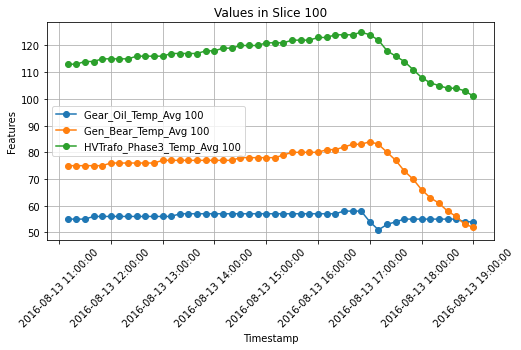

42
Slice 102 (Rows: 13):
Timestamp
2016-08-14 03:10:00+00:00    80.0
2016-08-14 03:20:00+00:00    80.0
2016-08-14 03:40:00+00:00    81.0
2016-08-14 03:50:00+00:00    81.0
2016-08-14 04:00:00+00:00    81.0
2016-08-14 04:10:00+00:00    81.0
2016-08-14 04:20:00+00:00    81.0
2016-08-14 04:30:00+00:00    81.0
2016-08-14 04:40:00+00:00    81.0
2016-08-14 04:50:00+00:00    81.0
2016-08-14 05:10:00+00:00    80.0
2016-08-14 05:20:00+00:00    80.0
2016-08-14 05:30:00+00:00    79.0
Name: Gen_Bear_Temp_Avg, dtype: float64



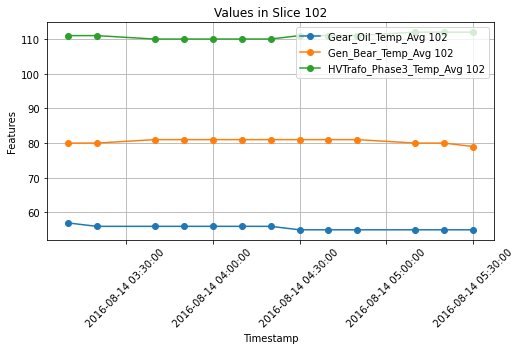

43
Slice 103 (Rows: 41):
Timestamp
2016-08-14 09:20:00+00:00    75.0
2016-08-14 09:30:00+00:00    75.0
2016-08-14 09:40:00+00:00    75.0
2016-08-14 10:00:00+00:00    75.0
2016-08-14 10:20:00+00:00    76.0
2016-08-14 10:30:00+00:00    76.0
2016-08-14 10:40:00+00:00    76.0
2016-08-14 10:50:00+00:00    76.0
2016-08-14 11:00:00+00:00    76.0
2016-08-14 11:10:00+00:00    76.0
2016-08-14 11:20:00+00:00    77.0
2016-08-14 11:30:00+00:00    77.0
2016-08-14 11:40:00+00:00    77.0
2016-08-14 11:50:00+00:00    77.0
2016-08-14 12:00:00+00:00    78.0
2016-08-14 12:10:00+00:00    78.0
2016-08-14 12:20:00+00:00    78.0
2016-08-14 12:30:00+00:00    78.0
2016-08-14 12:40:00+00:00    79.0
2016-08-14 12:50:00+00:00    79.0
2016-08-14 13:00:00+00:00    79.0
2016-08-14 13:10:00+00:00    79.0
2016-08-14 13:20:00+00:00    79.0
2016-08-14 13:30:00+00:00    79.0
2016-08-14 13:40:00+00:00    80.0
2016-08-14 13:50:00+00:00    80.0
2016-08-14 14:00:00+00:00    80.0
2016-08-14 14:10:00+00:00    80.0
2016-08-14 14

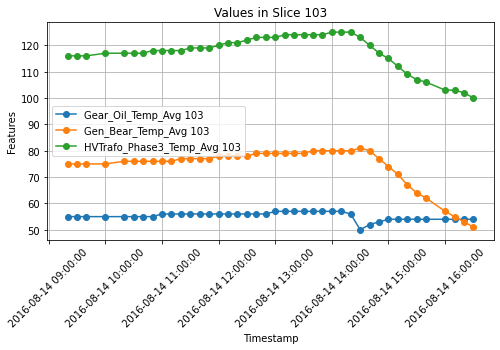

44
Slice 104 (Rows: 30):
Timestamp
2016-08-21 15:40:00+00:00    74.0
2016-08-21 15:50:00+00:00    75.0
2016-08-21 16:00:00+00:00    76.0
2016-08-21 16:10:00+00:00    76.0
2016-08-21 16:20:00+00:00    77.0
2016-08-21 16:30:00+00:00    77.0
2016-08-21 16:40:00+00:00    77.0
2016-08-21 16:50:00+00:00    77.0
2016-08-21 17:00:00+00:00    77.0
2016-08-21 17:10:00+00:00    78.0
2016-08-21 17:20:00+00:00    78.0
2016-08-21 17:30:00+00:00    78.0
2016-08-21 17:40:00+00:00    78.0
2016-08-21 17:50:00+00:00    79.0
2016-08-21 18:00:00+00:00    79.0
2016-08-21 18:10:00+00:00    79.0
2016-08-21 18:20:00+00:00    79.0
2016-08-21 18:30:00+00:00    79.0
2016-08-21 18:50:00+00:00    78.0
2016-08-21 19:00:00+00:00    78.0
2016-08-21 19:10:00+00:00    78.0
2016-08-21 19:20:00+00:00    78.0
2016-08-21 19:30:00+00:00    78.0
2016-08-21 19:40:00+00:00    79.0
2016-08-21 19:50:00+00:00    80.0
2016-08-21 20:00:00+00:00    80.0
2016-08-21 20:10:00+00:00    78.0
2016-08-21 20:20:00+00:00    75.0
2016-08-21 20

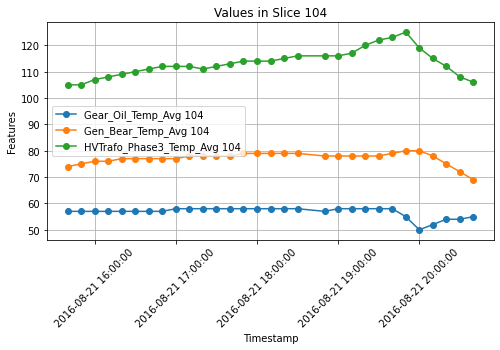

45
Slice 106 (Rows: 31):
Timestamp
2016-08-22 11:00:00+00:00    74.0
2016-08-22 11:10:00+00:00    74.0
2016-08-22 11:20:00+00:00    75.0
2016-08-22 11:30:00+00:00    75.0
2016-08-22 11:40:00+00:00    76.0
2016-08-22 11:50:00+00:00    76.0
2016-08-22 12:00:00+00:00    77.0
2016-08-22 12:10:00+00:00    77.0
2016-08-22 12:20:00+00:00    77.0
2016-08-22 12:30:00+00:00    77.0
2016-08-22 12:40:00+00:00    77.0
2016-08-22 12:50:00+00:00    77.0
2016-08-22 13:00:00+00:00    78.0
2016-08-22 13:10:00+00:00    78.0
2016-08-22 13:20:00+00:00    78.0
2016-08-22 13:30:00+00:00    78.0
2016-08-22 13:40:00+00:00    79.0
2016-08-22 13:50:00+00:00    80.0
2016-08-22 14:00:00+00:00    79.0
2016-08-22 14:10:00+00:00    77.0
2016-08-22 14:20:00+00:00    74.0
2016-08-22 14:30:00+00:00    71.0
2016-08-22 14:40:00+00:00    68.0
2016-08-22 14:50:00+00:00    65.0
2016-08-22 15:00:00+00:00    63.0
2016-08-22 15:10:00+00:00    60.0
2016-08-22 15:20:00+00:00    58.0
2016-08-22 15:30:00+00:00    56.0
2016-08-22 15

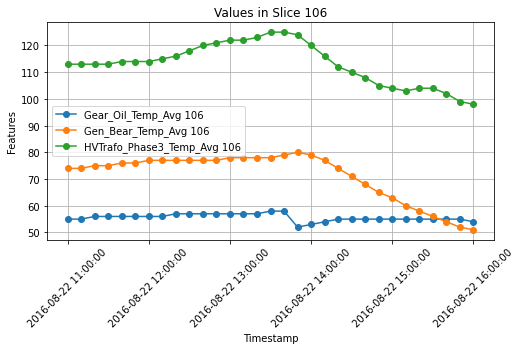

46
Slice 109 (Rows: 22):
Timestamp
2016-08-23 10:20:00+00:00    74.0
2016-08-23 10:40:00+00:00    75.0
2016-08-23 10:50:00+00:00    75.0
2016-08-23 11:00:00+00:00    75.0
2016-08-23 11:10:00+00:00    76.0
2016-08-23 11:20:00+00:00    76.0
2016-08-23 11:30:00+00:00    76.0
2016-08-23 11:40:00+00:00    76.0
2016-08-23 11:50:00+00:00    77.0
2016-08-23 12:00:00+00:00    77.0
2016-08-23 12:10:00+00:00    77.0
2016-08-23 12:20:00+00:00    77.0
2016-08-23 12:30:00+00:00    78.0
2016-08-23 12:40:00+00:00    78.0
2016-08-23 12:50:00+00:00    79.0
2016-08-23 13:00:00+00:00    79.0
2016-08-23 13:10:00+00:00    77.0
2016-08-23 13:20:00+00:00    75.0
2016-08-23 13:30:00+00:00    72.0
2016-08-23 13:40:00+00:00    69.0
2016-08-23 13:50:00+00:00    66.0
2016-08-23 14:00:00+00:00    63.0
Name: Gen_Bear_Temp_Avg, dtype: float64



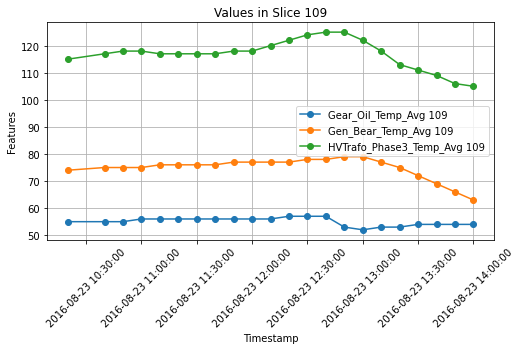

47
Slice 112 (Rows: 27):
Timestamp
2016-08-24 08:50:00+00:00    73.0
2016-08-24 09:00:00+00:00    74.0
2016-08-24 09:10:00+00:00    74.0
2016-08-24 09:20:00+00:00    74.0
2016-08-24 09:30:00+00:00    75.0
2016-08-24 09:40:00+00:00    75.0
2016-08-24 09:50:00+00:00    75.0
2016-08-24 10:00:00+00:00    75.0
2016-08-24 10:10:00+00:00    76.0
2016-08-24 10:20:00+00:00    76.0
2016-08-24 10:30:00+00:00    76.0
2016-08-24 10:40:00+00:00    76.0
2016-08-24 10:50:00+00:00    76.0
2016-08-24 11:00:00+00:00    76.0
2016-08-24 11:10:00+00:00    77.0
2016-08-24 11:20:00+00:00    77.0
2016-08-24 11:30:00+00:00    77.0
2016-08-24 11:40:00+00:00    77.0
2016-08-24 11:50:00+00:00    77.0
2016-08-24 12:00:00+00:00    78.0
2016-08-24 12:10:00+00:00    77.0
2016-08-24 12:20:00+00:00    75.0
2016-08-24 12:30:00+00:00    72.0
2016-08-24 12:40:00+00:00    69.0
2016-08-24 12:50:00+00:00    66.0
2016-08-24 13:00:00+00:00    64.0
2016-08-24 13:10:00+00:00    61.0
Name: Gen_Bear_Temp_Avg, dtype: float64



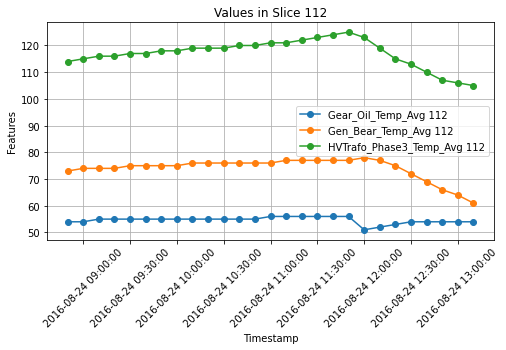

48
Slice 115 (Rows: 21):
Timestamp
2016-08-25 09:30:00+00:00    76.0
2016-08-25 09:50:00+00:00    77.0
2016-08-25 10:00:00+00:00    77.0
2016-08-25 10:10:00+00:00    77.0
2016-08-25 10:20:00+00:00    77.0
2016-08-25 10:30:00+00:00    77.0
2016-08-25 10:40:00+00:00    77.0
2016-08-25 10:50:00+00:00    78.0
2016-08-25 11:00:00+00:00    78.0
2016-08-25 11:10:00+00:00    78.0
2016-08-25 11:20:00+00:00    78.0
2016-08-25 11:30:00+00:00    78.0
2016-08-25 11:40:00+00:00    78.0
2016-08-25 11:50:00+00:00    79.0
2016-08-25 12:00:00+00:00    80.0
2016-08-25 12:10:00+00:00    79.0
2016-08-25 12:20:00+00:00    76.0
2016-08-25 12:30:00+00:00    73.0
2016-08-25 12:40:00+00:00    70.0
2016-08-25 12:50:00+00:00    67.0
2016-08-25 13:00:00+00:00    64.0
Name: Gen_Bear_Temp_Avg, dtype: float64



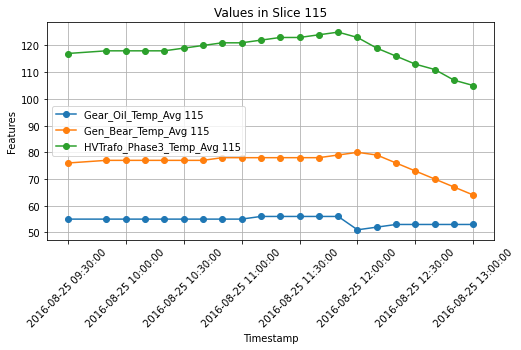

49
Slice 117 (Rows: 27):
Timestamp
2016-08-26 12:00:00+00:00    71.0
2016-08-26 12:10:00+00:00    72.0
2016-08-26 12:20:00+00:00    73.0
2016-08-26 12:30:00+00:00    74.0
2016-08-26 12:40:00+00:00    74.0
2016-08-26 12:50:00+00:00    75.0
2016-08-26 13:00:00+00:00    75.0
2016-08-26 13:10:00+00:00    76.0
2016-08-26 13:20:00+00:00    76.0
2016-08-26 13:30:00+00:00    76.0
2016-08-26 13:40:00+00:00    77.0
2016-08-26 13:50:00+00:00    77.0
2016-08-26 14:00:00+00:00    77.0
2016-08-26 14:10:00+00:00    78.0
2016-08-26 14:20:00+00:00    78.0
2016-08-26 14:30:00+00:00    78.0
2016-08-26 14:40:00+00:00    78.0
2016-08-26 14:50:00+00:00    79.0
2016-08-26 15:00:00+00:00    80.0
2016-08-26 15:10:00+00:00    79.0
2016-08-26 15:20:00+00:00    77.0
2016-08-26 15:30:00+00:00    74.0
2016-08-26 15:40:00+00:00    71.0
2016-08-26 15:50:00+00:00    68.0
2016-08-26 16:00:00+00:00    65.0
2016-08-26 16:10:00+00:00    63.0
2016-08-26 16:30:00+00:00    58.0
Name: Gen_Bear_Temp_Avg, dtype: float64



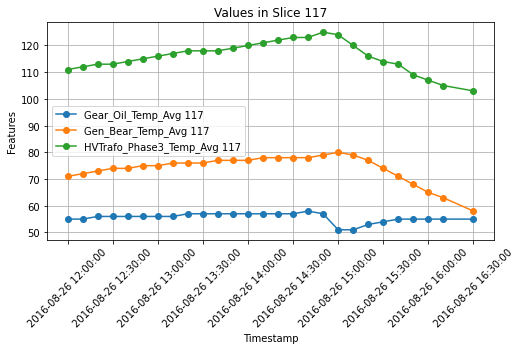

50
Slice 119 (Rows: 44):
Timestamp
2016-09-01 12:50:00+00:00    73.0
2016-09-01 13:00:00+00:00    74.0
2016-09-01 13:10:00+00:00    75.0
2016-09-01 13:20:00+00:00    75.0
2016-09-01 13:30:00+00:00    76.0
2016-09-01 13:40:00+00:00    77.0
2016-09-01 13:50:00+00:00    77.0
2016-09-01 14:00:00+00:00    77.0
2016-09-01 14:10:00+00:00    78.0
2016-09-01 14:20:00+00:00    78.0
2016-09-01 14:30:00+00:00    78.0
2016-09-01 14:40:00+00:00    79.0
2016-09-01 14:50:00+00:00    79.0
2016-09-01 15:00:00+00:00    79.0
2016-09-01 15:10:00+00:00    79.0
2016-09-01 15:20:00+00:00    80.0
2016-09-01 15:30:00+00:00    81.0
2016-09-01 15:40:00+00:00    82.0
2016-09-01 15:50:00+00:00    83.0
2016-09-01 16:00:00+00:00    85.0
2016-09-01 16:10:00+00:00    87.0
2016-09-01 16:20:00+00:00    89.0
2016-09-01 16:30:00+00:00    89.0
2016-09-01 16:40:00+00:00    90.0
2016-09-01 16:50:00+00:00    90.0
2016-09-01 17:00:00+00:00    90.0
2016-09-01 17:10:00+00:00    90.0
2016-09-01 17:20:00+00:00    90.0
2016-09-01 17

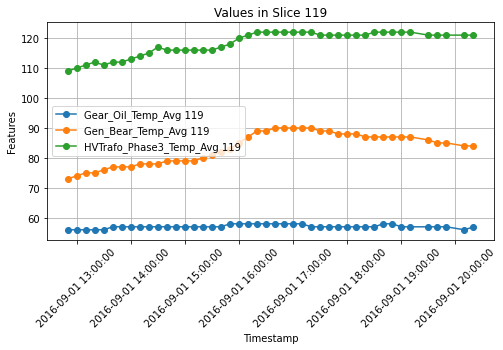

51
Slice 120 (Rows: 14):
Timestamp
2016-09-01 21:10:00+00:00    81.0
2016-09-01 21:20:00+00:00    81.0
2016-09-01 21:30:00+00:00    81.0
2016-09-01 21:40:00+00:00    81.0
2016-09-01 21:50:00+00:00    80.0
2016-09-01 22:00:00+00:00    80.0
2016-09-01 22:10:00+00:00    80.0
2016-09-01 22:20:00+00:00    79.0
2016-09-01 22:30:00+00:00    80.0
2016-09-01 22:40:00+00:00    79.0
2016-09-01 22:50:00+00:00    77.0
2016-09-01 23:00:00+00:00    74.0
2016-09-01 23:10:00+00:00    70.0
2016-09-01 23:20:00+00:00    67.0
Name: Gen_Bear_Temp_Avg, dtype: float64



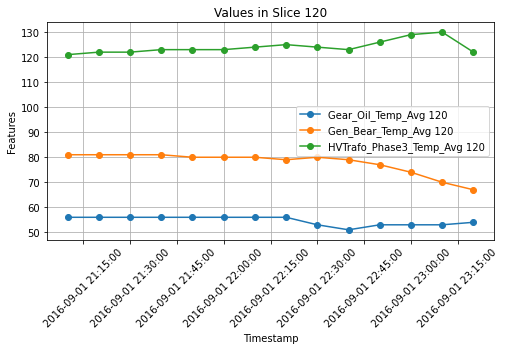

52
Slice 128 (Rows: 14):
Timestamp
2016-09-05 14:50:00+00:00    62.0
2016-09-05 15:00:00+00:00    62.0
2016-09-05 15:10:00+00:00    61.0
2016-09-05 15:20:00+00:00    60.0
2016-09-05 15:30:00+00:00    59.0
2016-09-05 15:40:00+00:00    58.0
2016-09-05 15:50:00+00:00    57.0
2016-09-05 16:00:00+00:00    56.0
2016-09-05 16:10:00+00:00    56.0
2016-09-05 16:20:00+00:00    55.0
2016-09-05 16:30:00+00:00    54.0
2016-09-05 16:40:00+00:00    54.0
2016-09-05 16:50:00+00:00    53.0
2016-09-05 17:00:00+00:00    53.0
Name: Gen_Bear_Temp_Avg, dtype: float64



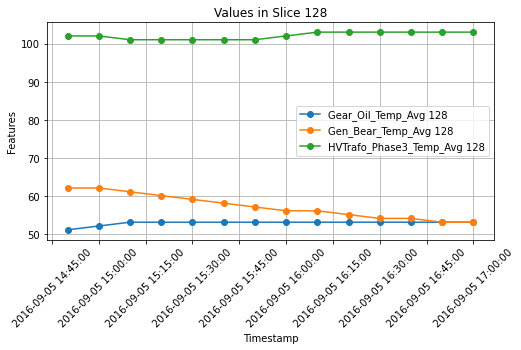

53
Slice 136 (Rows: 17):
Timestamp
2016-09-28 12:10:00+00:00    71.0
2016-09-28 12:20:00+00:00    72.0
2016-09-28 12:30:00+00:00    72.0
2016-09-28 12:40:00+00:00    73.0
2016-09-28 12:50:00+00:00    73.0
2016-09-28 13:00:00+00:00    74.0
2016-09-28 13:10:00+00:00    75.0
2016-09-28 13:20:00+00:00    74.0
2016-09-28 13:30:00+00:00    73.0
2016-09-28 13:40:00+00:00    70.0
2016-09-28 13:50:00+00:00    67.0
2016-09-28 14:00:00+00:00    64.0
2016-09-28 14:10:00+00:00    62.0
2016-09-28 14:20:00+00:00    59.0
2016-09-28 14:30:00+00:00    57.0
2016-09-28 14:50:00+00:00    53.0
2016-09-28 15:00:00+00:00    51.0
Name: Gen_Bear_Temp_Avg, dtype: float64



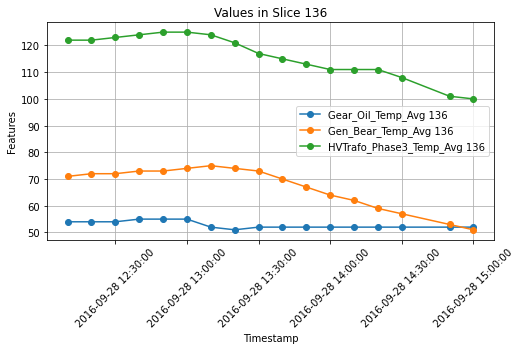

54
Slice 139 (Rows: 21):
Timestamp
2016-09-28 22:00:00+00:00    73.0
2016-09-28 22:10:00+00:00    73.0
2016-09-28 22:20:00+00:00    73.0
2016-09-28 22:30:00+00:00    74.0
2016-09-28 22:40:00+00:00    74.0
2016-09-28 22:50:00+00:00    74.0
2016-09-28 23:00:00+00:00    74.0
2016-09-28 23:10:00+00:00    74.0
2016-09-28 23:20:00+00:00    74.0
2016-09-28 23:30:00+00:00    74.0
2016-09-28 23:40:00+00:00    74.0
2016-09-28 23:50:00+00:00    74.0
2016-09-29 00:00:00+00:00    74.0
2016-09-29 00:10:00+00:00    74.0
2016-09-29 00:20:00+00:00    74.0
2016-09-29 00:30:00+00:00    74.0
2016-09-29 00:40:00+00:00    74.0
2016-09-29 00:50:00+00:00    74.0
2016-09-29 01:00:00+00:00    74.0
2016-09-29 01:10:00+00:00    74.0
2016-09-29 01:20:00+00:00    74.0
Name: Gen_Bear_Temp_Avg, dtype: float64



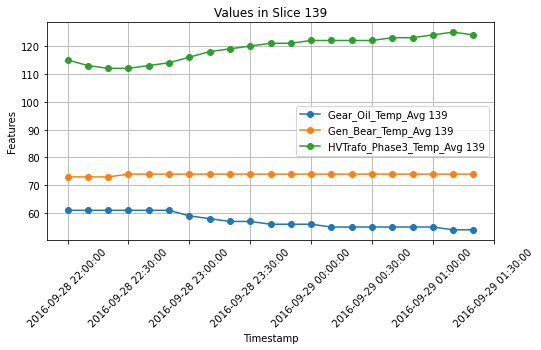

55
Slice 142 (Rows: 8):
Timestamp
2016-09-29 07:50:00+00:00    75.0
2016-09-29 08:00:00+00:00    76.0
2016-09-29 08:10:00+00:00    76.0
2016-09-29 08:20:00+00:00    74.0
2016-09-29 08:30:00+00:00    71.0
2016-09-29 08:40:00+00:00    68.0
2016-09-29 08:50:00+00:00    64.0
2016-09-29 09:00:00+00:00    61.0
Name: Gen_Bear_Temp_Avg, dtype: float64



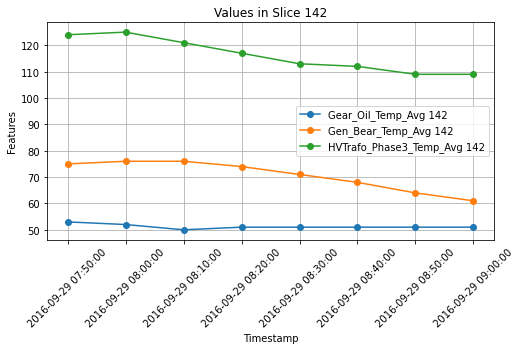

56
Slice 143 (Rows: 19):
Timestamp
2016-09-29 12:20:00+00:00    35.0
2016-09-29 12:30:00+00:00    35.0
2016-09-29 12:40:00+00:00    35.0
2016-09-29 12:50:00+00:00    35.0
2016-09-29 13:00:00+00:00    34.0
2016-09-29 13:10:00+00:00    34.0
2016-09-29 13:20:00+00:00    34.0
2016-09-29 13:30:00+00:00    34.0
2016-09-29 13:40:00+00:00    33.0
2016-09-29 13:50:00+00:00    33.0
2016-09-29 14:00:00+00:00    33.0
2016-09-29 14:10:00+00:00    33.0
2016-09-29 14:20:00+00:00    33.0
2016-09-29 14:30:00+00:00    33.0
2016-09-29 14:40:00+00:00    33.0
2016-09-29 15:00:00+00:00    33.0
2016-09-29 15:10:00+00:00    33.0
2016-09-29 15:20:00+00:00    33.0
2016-09-29 15:30:00+00:00    33.0
Name: Gen_Bear_Temp_Avg, dtype: float64



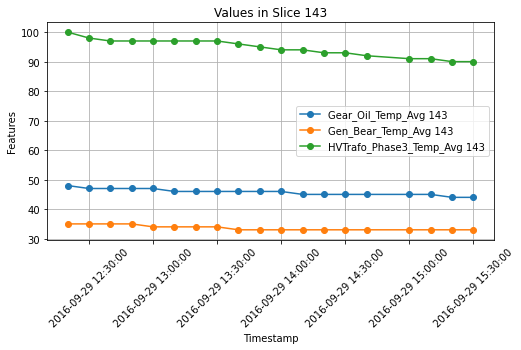

57
Slice 144 (Rows: 12):
Timestamp
2016-09-29 18:00:00+00:00    67.0
2016-09-29 18:10:00+00:00    69.0
2016-09-29 18:20:00+00:00    69.0
2016-09-29 18:30:00+00:00    70.0
2016-09-29 18:40:00+00:00    71.0
2016-09-29 18:50:00+00:00    72.0
2016-09-29 19:00:00+00:00    73.0
2016-09-29 19:10:00+00:00    73.0
2016-09-29 19:20:00+00:00    74.0
2016-09-29 19:30:00+00:00    74.0
2016-09-29 19:50:00+00:00    75.0
2016-09-29 20:00:00+00:00    75.0
Name: Gen_Bear_Temp_Avg, dtype: float64



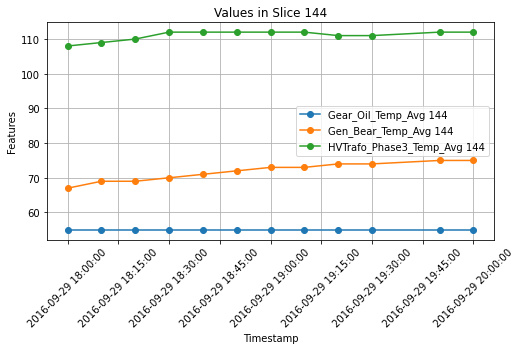

58
Slice 145 (Rows: 9):
Timestamp
2016-10-12 12:40:00+00:00    70.0
2016-10-12 12:50:00+00:00    70.0
2016-10-12 13:00:00+00:00    69.0
2016-10-12 13:10:00+00:00    67.0
2016-10-12 13:20:00+00:00    64.0
2016-10-12 13:30:00+00:00    61.0
2016-10-12 13:40:00+00:00    58.0
2016-10-12 13:50:00+00:00    55.0
2016-10-12 14:00:00+00:00    52.0
Name: Gen_Bear_Temp_Avg, dtype: float64



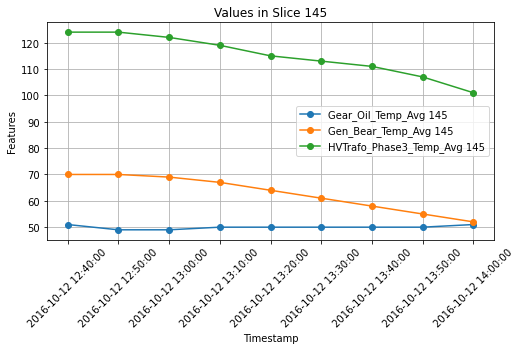

59
Slice 148 (Rows: 11):
Timestamp
2016-10-27 10:10:00+00:00    72.0
2016-10-27 10:30:00+00:00    73.0
2016-10-27 10:40:00+00:00    74.0
2016-10-27 10:50:00+00:00    73.0
2016-10-27 11:00:00+00:00    70.0
2016-10-27 11:10:00+00:00    68.0
2016-10-27 11:20:00+00:00    65.0
2016-10-27 11:30:00+00:00    62.0
2016-10-27 11:40:00+00:00    59.0
2016-10-27 11:50:00+00:00    57.0
2016-10-27 12:10:00+00:00    52.0
Name: Gen_Bear_Temp_Avg, dtype: float64



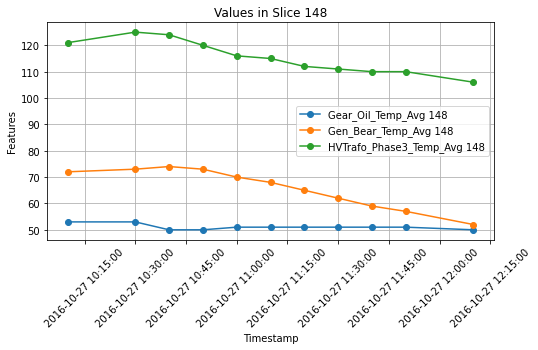

60
Slice 150 (Rows: 25):
Timestamp
2016-10-28 00:40:00+00:00    69.0
2016-10-28 00:50:00+00:00    70.0
2016-10-28 01:00:00+00:00    70.0
2016-10-28 01:10:00+00:00    71.0
2016-10-28 01:20:00+00:00    72.0
2016-10-28 01:30:00+00:00    72.0
2016-10-28 01:40:00+00:00    72.0
2016-10-28 01:50:00+00:00    72.0
2016-10-28 02:00:00+00:00    73.0
2016-10-28 02:10:00+00:00    73.0
2016-10-28 02:20:00+00:00    73.0
2016-10-28 02:30:00+00:00    74.0
2016-10-28 02:40:00+00:00    74.0
2016-10-28 02:50:00+00:00    74.0
2016-10-28 03:00:00+00:00    74.0
2016-10-28 03:10:00+00:00    73.0
2016-10-28 03:20:00+00:00    71.0
2016-10-28 03:30:00+00:00    69.0
2016-10-28 03:40:00+00:00    66.0
2016-10-28 03:50:00+00:00    63.0
2016-10-28 04:00:00+00:00    60.0
2016-10-28 04:10:00+00:00    57.0
2016-10-28 04:20:00+00:00    54.0
2016-10-28 04:30:00+00:00    52.0
2016-10-28 04:50:00+00:00    48.0
Name: Gen_Bear_Temp_Avg, dtype: float64



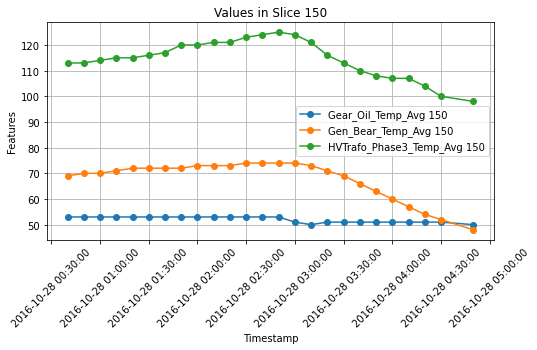

61
Slice 154 (Rows: 12):
Timestamp
2016-10-28 16:40:00+00:00    75.0
2016-10-28 16:50:00+00:00    75.0
2016-10-28 17:00:00+00:00    75.0
2016-10-28 17:10:00+00:00    76.0
2016-10-28 17:20:00+00:00    76.0
2016-10-28 17:30:00+00:00    75.0
2016-10-28 17:40:00+00:00    73.0
2016-10-28 17:50:00+00:00    71.0
2016-10-28 18:00:00+00:00    67.0
2016-10-28 18:10:00+00:00    64.0
2016-10-28 18:20:00+00:00    62.0
2016-10-28 18:30:00+00:00    59.0
Name: Gen_Bear_Temp_Avg, dtype: float64



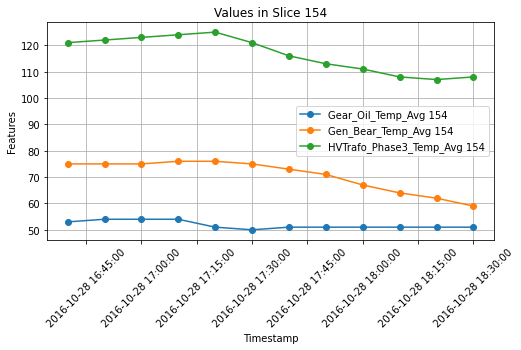

62
Slice 158 (Rows: 21):
Timestamp
2016-10-29 09:20:00+00:00    73.0
2016-10-29 09:30:00+00:00    73.0
2016-10-29 09:40:00+00:00    73.0
2016-10-29 09:50:00+00:00    73.0
2016-10-29 10:00:00+00:00    73.0
2016-10-29 10:10:00+00:00    73.0
2016-10-29 10:20:00+00:00    73.0
2016-10-29 10:30:00+00:00    73.0
2016-10-29 10:40:00+00:00    73.0
2016-10-29 10:50:00+00:00    73.0
2016-10-29 11:00:00+00:00    73.0
2016-10-29 11:10:00+00:00    74.0
2016-10-29 11:20:00+00:00    73.0
2016-10-29 11:30:00+00:00    71.0
2016-10-29 11:40:00+00:00    68.0
2016-10-29 11:50:00+00:00    65.0
2016-10-29 12:00:00+00:00    62.0
2016-10-29 12:10:00+00:00    59.0
2016-10-29 12:20:00+00:00    56.0
2016-10-29 12:30:00+00:00    54.0
2016-10-29 12:40:00+00:00    51.0
Name: Gen_Bear_Temp_Avg, dtype: float64



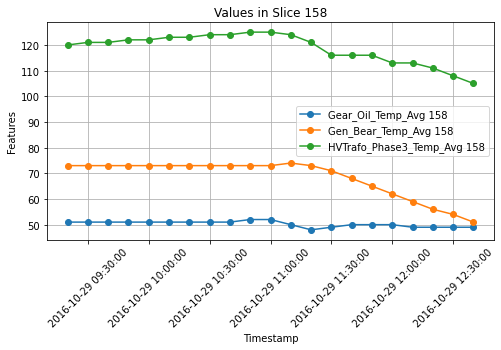

63


In [604]:
# Initialize variables
slices = []
current_slice = []

# Iterate through the index (timestamps)
for i, index in enumerate(anomaly_data.index):
    if i == 0:
        current_slice.append(index)
    elif (index - anomaly_data.index[i - 1]).total_seconds() / 60 <= 20:
        current_slice.append(index)
        #print('The condition was true')
    else:
        slices.append(current_slice.copy())
        current_slice = [index]

# Append the last slice
if current_slice:
    slices.append(current_slice)

# Plot the values in each slice with timestamps on the x-axis

#B=my_Gen_Bear.Gen_Bear_Temp_Avg.values.reshape(1, -1)
##my_Gen_Bear['Gen_Bear_Temp_Avg']=scaler.inverse_transform(B)
#i=0
extrait = 0
for i, slice_indices in enumerate(slices):
    
    slice_df = anomaly_data.loc[slice_indices]
    
    if len(slice_indices) >= 8: # environ 2 heures
        print(extrait)
        extrait = extrait + 1
        # Only plot slices with more than 9 rows
        #print(f"Slice {i + 1} (Rows: {len(slice_indices)}):\n{slice_df['Gen_Bear_Temp_Avg']}")
        print(f"Slice {i + 1} (Rows: {len(slice_indices)}):\n{slice_df['Gen_Bear_Temp_Avg']}")
        #print(f"Extrait d\'une intervalle numéro {i + 1} (Rows: {len(slice_indices)}):\n")
        #print(slice_indices)
        print()
        plt.figure(figsize=(8, 4))  # Adjust figure size as needed
        #plt.plot(slice_df.index, slice_df['Gen_Bear_Temp_Avg'], marker='o', linestyle='-', label=f'Gen_Bear_Temp_Avg {i + 1}')
        #plt.plot(slice_df.index, slice_df['Gen_Bear2_Temp_Avg'], marker='o', linestyle='-', label=f'Gen_Bear2_Temp_Avg {i + 1}')
        #plt.plot(slice_df.index, slice_df['Gear_Bear_Temp_Avg'], marker='o', linestyle='-', label=f'Gear_Bear_Temp_Avg {i + 1}')
        plt.plot(slice_df.index, slice_df['Gear_Oil_Temp_Avg'], marker='o', linestyle='-', label=f'Gear_Oil_Temp_Avg {i + 1}')
        plt.plot(slice_df.index, slice_df['Gen_Bear_Temp_Avg'], marker='o', linestyle='-', label=f'Gen_Bear_Temp_Avg {i + 1}')
        plt.plot(slice_df.index, slice_df['HVTrafo_Phase3_Temp_Avg'], marker='o', linestyle='-', label=f'HVTrafo_Phase3_Temp_Avg {i + 1}')
        #plt.plot(slice_df.index, slice_df['Gen_RPM_Std'], marker='o', linestyle='-', label=f'Gen_RPM_Std {i + 1}')
        #plt.plot(slice_df.index, slice_df['Grd_Prod_PsbleCap_Avg'], marker='o', linestyle='-', label=f'Grd_Prod_PsbleCap_Avg {i + 1}')
        #plt.plot(slice_df.index, slice_df['Gen_RPM_Min'], marker='o', linestyle='-', label=f'Gen_RPM_Min {i + 1}')
        plt.title(f'Values in Slice {i + 1}')
        plt.xlabel('Timestamp')
        plt.ylabel('Features')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
        plt.legend()
        plt.grid(True)
        plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M:%S'))
        plt.show()
print(extrait)

In [605]:
'''
import matplotlib.pyplot as plt
from matplotlib.dates import (YEARLY, DateFormatter,rrulewrapper, RRuleLocator, drange)
for i in range(len(predicted_data)):
        #mse = np.mean((data0[i] - reconstructed_data[i] ** 2))
        mse = mean_squared_error(predicted_data[i], df_anomalie1.values[i])
        #print(mse)
        if  mse >= 3 :
            #y=data0[i]
            rowb=i
            #print(rowb)
            #df = pd.DataFrame(df_anomalie1)
            # Plotting
            plt.plot(df_anomalie3[rowb-10:rowb+10])
            #plt.plot(df_anomalie[0:5000])
            plt.xlabel('Datetime')
            plt.xticks(rotation=45)
            plt.ylabel("Transformer's temperature [°C]")
            plt.title('Anomalie detection')
            plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d %H:%M:%S'))
            # Display the plot
            plt.show()
'''

'\nimport matplotlib.pyplot as plt\nfrom matplotlib.dates import (YEARLY, DateFormatter,rrulewrapper, RRuleLocator, drange)\nfor i in range(len(predicted_data)):\n        #mse = np.mean((data0[i] - reconstructed_data[i] ** 2))\n        mse = mean_squared_error(predicted_data[i], df_anomalie1.values[i])\n        #print(mse)\n        if  mse >= 3 :\n            #y=data0[i]\n            rowb=i\n            #print(rowb)\n            #df = pd.DataFrame(df_anomalie1)\n            # Plotting\n            plt.plot(df_anomalie3[rowb-10:rowb+10])\n            #plt.plot(df_anomalie[0:5000])\n            plt.xlabel(\'Datetime\')\n            plt.xticks(rotation=45)\n            plt.ylabel("Transformer\'s temperature [°C]")\n            plt.title(\'Anomalie detection\')\n            plt.gca().xaxis.set_major_formatter(DateFormatter(\'%Y-%m-%d %H:%M:%S\'))\n            # Display the plot\n            plt.show()\n'

In [606]:
predicted_data
#df_anomalie1

,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,...,Grd_Prod_PsblePwr_Std,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 00:10:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 00:20:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 00:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 00:40:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:10:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-31 23:20:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-31 23:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [607]:
#predicted_data
#predicted_data.drop(columns=['index'],inplace=True)

In [608]:
import copy

In [665]:

start_date2="2016-04-29 18:10:00+00:00"
end_date2="2016-04-29 19:30:00+00:00"
#start_date2="2016-07-10 02:00:00+00:00"
#end_date2="2016-07-10 06:20:00+00:00"
#start_date2= "2016-08-23 10:20:00+00:00"
#end_date2="2016-08-23 14:00:00+00:00"
#start_date2="2016-07-10 00:20:00"
#end_date2="2016-07-10 05:00:00"

#start_date2="2016-07-10 01:50:00"
#end_date2="2016-07-10 05:10:00"

#start_date2="2016-07-14 11:10:00"
#end_date2="2016-07-14 16:30:00"

#start_date2="2016-08-23 10:20:00"
#end_date2="2016-08-23 14:00:00"

#start_date2="2017-06-17 15:20:00"
#end_date2="2017-06-17 18:40:00"


start_date2 = pd.Timestamp(start_date2)
end_date2= pd.Timestamp(end_date2)
#anomaly_data.reset_index(inplace=True)

In [666]:
reconstructed_data = predicted_data.copy()
reconstructed_data.reset_index(inplace=True)
reconstructed_data1 = reconstructed_data[(reconstructed_data['Timestamp'] >= start_date2) & (reconstructed_data['Timestamp'] <= end_date2)]
reconstructed_data1.set_index('Timestamp', inplace=True) 
reconstructed_data1 = reconstructed_data1[reconstructed_data1.columns].mean(axis=0)
reconstructed_data1 = reconstructed_data1.to_frame().T
reconstructed_data1

,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,...,Grd_Prod_PsblePwr_Std,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [667]:
'''
reconstructed_data = predicted_data.copy()
reconstructed_data.reset_index(inplace=True)
reconstructed_data1 = reconstructed_data[reconstructed_data['Timestamp'] == '2016-04-29 18:10:00'] #'2016-04-29 18:10:00'
reconstructed_data1.set_index('Timestamp', inplace=True) 
reconstructed_data1
'''

"\nreconstructed_data = predicted_data.copy()\nreconstructed_data.reset_index(inplace=True)\nreconstructed_data1 = reconstructed_data[reconstructed_data['Timestamp'] == '2016-04-29 18:10:00'] #'2016-04-29 18:10:00'\nreconstructed_data1.set_index('Timestamp', inplace=True) \nreconstructed_data1\n"

In [668]:
#df_anomalie1.drop(columns=['level_0','index'],inplace=True)
#df_anomalie1

In [669]:
g1_original = df_anomalie1[df_anomalie1.columns[:-2]].copy()
g1_original.reset_index(inplace=True)
g2_original=g1_original[(g1_original['Timestamp'] >= start_date2) & (g1_original['Timestamp'] <= end_date2)]
g2_original.set_index('Timestamp',inplace=True) 
g2_original = g2_original[g2_original.columns].mean(axis=0)
g2_original = g2_original.to_frame().T
g2_original
#g1_original=anomaly_data[0:1].values[0]

,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,...,Grd_Prod_PsblePwr_Std,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg
0,-0.860891,-1.480291,-1.369705,1.551557,5.709015,0.253417,0.265429,0.316561,1.330725,0.696504,...,3.158444,1.035899,0.941526,0.744044,0.668598,-1.030373,-0.7164,-0.892453,0.344527,0.493495


In [670]:
'''
g1_original = df_anomalie1[df_anomalie1.columns[:-2]].copy()
g1_original.reset_index(inplace=True)
g2_original = g1_original[g1_original['Timestamp'] == '2016-04-29 18:10:00'] #'2016-04-29 18:10:00'
g2_original.set_index('Timestamp',inplace=True) 
g2_original
'''

"\ng1_original = df_anomalie1[df_anomalie1.columns[:-2]].copy()\ng1_original.reset_index(inplace=True)\ng2_original = g1_original[g1_original['Timestamp'] == '2016-04-29 18:10:00'] #'2016-04-29 18:10:00'\ng2_original.set_index('Timestamp',inplace=True) \ng2_original\n"

In [671]:
len(g2_original.values[0])

64

In [672]:
def show_local_explaination(list_to_explain,
                      original_data_point,
                      invert_transform,
                      data_train,
                      impact_pourcentage = 50 ,
                      plot=False,
                      sort=False,
                      show_pourcentage=False):
    exp_data = pd.DataFrame(list_to_explain)
    exp_data = exp_data.T
    exp_data.columns = data_train.columns
    col_to_scale = list(data_train.columns)
    #print(col_to_scale,len(col_to_scale))
    if invert_transform :
        #scaler = StandardScaler() #MinMaxScaler()
        ssx.fit(data_train[col_to_scale])
        exp_inverted = pd.DataFrame()
        org_inverted = pd.DataFrame()
        exp_inverted[col_to_scale] = ssx.inverse_transform(exp_data[col_to_scale])
        org_inverted[col_to_scale] = ssx.inverse_transform(original_data_point[col_to_scale])

        result = pd.concat([org_inverted,exp_inverted]).T
        
    else :
        result = pd.concat([original_data_point[col_to_scale],exp_data[col_to_scale]]).T
        
    result.columns = ['real_data_point','optimal_values']
    #print(result.head(20))
    #Here is the most important part of the code
    #------------------------------------------------------------------------------------------------------------------
    result['impact'] = result.apply(lambda row: np.mean((row[result.columns[0]] - row[result.columns[1]])**2), axis=1)
    result['Polarity'] = result.apply(lambda row: row[result.columns[0]] * row[result.columns[1]], axis=1)
    #result['Polarity'] = result[result.columns].apply(lambda x  : x[0] * x[1] , axis=1)
    #---------------------------------------------------------------------------------------------------------------------
    #result['impact']=np.mean((df_anomalie.Hyd_Oil_Temp_Avg.values[85485] - reconstructed_data.Hyd_Oil_Temp_Avg.values[85485])**2)
    #result['impact'] = result.apply(lambda row: (row['real_data_point'] - row['optimal_values']) / (abs(row['real_data_point']) + abs(row['optimal_values'])), axis=1)
    #max_abs_diff = result[['real_data_point', 'optimal_values']].abs().max().max()
    #result['impact'] = result.apply(lambda row: (row['real_data_point'] - row['optimal_values']) / max_abs_diff, axis=1)
    #result = result.fillna(0) 
    #full_deviation = result.impact.abs().sum()
    #result['pourcentage_impact'] = result['impact'].apply(lambda x : (abs(x)/result.impact.abs().sum())*100 )
    result['pourcentage_impact'] = result['impact'].apply(lambda x : x*1)
    result_copy = result.sort_values(by=['pourcentage_impact'],ascending=False)
    result_copy['pourc_cum'] = result_copy.pourcentage_impact.cumsum()
    #print(result_copy)
    print(result)
    impacting_variable_index = list(np.where(result_copy['pourc_cum'] > impact_pourcentage))[0][0]
    impacting_variable_line = (len(result) - impacting_variable_index ) - 1.4
    
    #Everything will start here since we set invert_transform to false
    
    if sort :
            result.sort_values(by=['pourcentage_impact'],ascending=False , inplace=True)
            result = result[0:10]
            impacting_variable_line = (len(result) - impacting_variable_index ) - 1.4
            result.sort_values(by=['pourcentage_impact'],ascending=True , inplace=True)
    if plot :
        limit = np.max(np.abs(result.impact.values)) 
        limit = limit + 0.1*limit
        fig, ax = plt.subplots(figsize=(10,6))
        ax.set_xlim([0,limit])
        #ax.set_xlim([-limit,limit])
        ax.barh(result.index, result['impact'], color='blue')
        container = ax.containers[0]
        if show_pourcentage :
            ax.bar_label(container, labels=[f'{x:,.2f} %' for x in list(result.pourcentage_impact)])
        ax.plot([-2, 2], [impacting_variable_line, impacting_variable_line], "k--",color='green')
        if show_pourcentage :
            ax.set_xlabel("pourcentage of deviation")
        else :
            ax.set_xlabel("deviation")
        ax.set_ylabel("features")
    else :
        return result
    
    return result

                       real_data_point  optimal_values     impact  Polarity  \
Gen_RPM_Max                        0.0       -0.860891   0.741133      -0.0   
Gen_RPM_Min                        0.0       -1.480291   2.191260      -0.0   
Gen_RPM_Avg                        0.0       -1.369705   1.876092      -0.0   
Gen_RPM_Std                        0.0        1.551557   2.407329       0.0   
Gen_Bear_Temp_Avg                  0.0        5.709015  32.592854       0.0   
...                                ...             ...        ...       ...   
Grd_Prod_PsbleCap_Avg              0.0       -1.030373   1.061669      -0.0   
Grd_Prod_PsbleCap_Max              0.0       -0.716400   0.513229      -0.0   
Grd_Prod_PsbleCap_Min              0.0       -0.892453   0.796472      -0.0   
Grd_Prod_PsbleCap_Std              0.0        0.344527   0.118699       0.0   
Gen_Bear2_Temp_Avg                 0.0        0.493495   0.243537       0.0   

                       pourcentage_impact  
Gen_RPM

C:\Users\r.randrianandraina\AppData\Local\Temp\ipykernel_23980\1914827987.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-2, 2], [impacting_variable_line, impacting_variable_line], "k--",color='green')


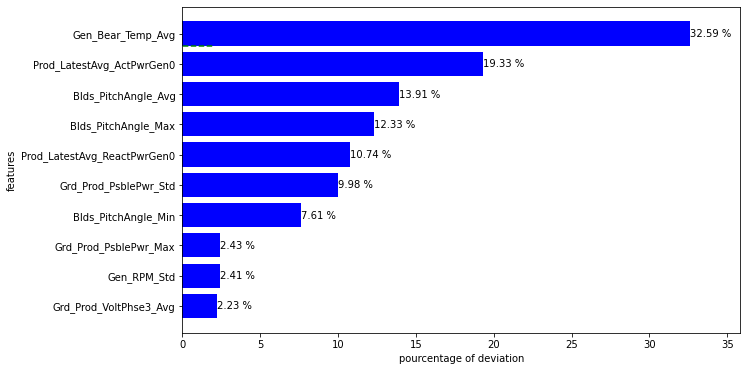

In [673]:
#f1 = pd.DataFrame(reconstructed_data[0:1], columns=my_col)
mydata = show_local_explaination(g2_original.values[0],reconstructed_data1,invert_transform=False,data_train=reconstructed_data1,impact_pourcentage=10,plot=True,sort=True,show_pourcentage=True)

In [674]:
mydata

,real_data_point,optimal_values,impact,Polarity,pourcentage_impact
Grd_Prod_VoltPhse3_Avg,0.0,1.492197,2.226653,0.0,2.226653
Gen_RPM_Std,0.0,1.551557,2.407329,0.0,2.407329
Grd_Prod_PsblePwr_Max,0.0,1.559062,2.430675,0.0,2.430675
Blds_PitchAngle_Min,0.0,2.758652,7.610160,0.0,7.610160
Grd_Prod_PsblePwr_Std,0.0,3.158444,9.975765,0.0,9.975765
Prod_LatestAvg_ReactPwrGen0,0.0,-3.276470,10.735254,-0.0,10.735254
Blds_PitchAngle_Max,0.0,3.511155,12.328211,0.0,12.328211
Blds_PitchAngle_Avg,0.0,3.729966,13.912648,0.0,13.912648
Prod_LatestAvg_ActPwrGen0,0.0,-4.396335,19.327761,-0.0,19.327761
Gen_Bear_Temp_Avg,0.0,5.709015,32.592854,0.0,32.592854


In [675]:
#Gearbox
Gearbox = ['Gear_Oil_Temp_Avg','Gear_Bear_Temp_Avg'] # Gearbox
#Nacelle
Nacelle = ['Nac_Temp_Avg','Cont_Top_Temp_Avg']
#Transformer 
Transformer = ['HVTrafo_Phase1_Temp_Avg','HVTrafo_Phase2_Temp_Avg','HVTrafo_Phase3_Temp_Avg'] #Transformer
#Hydraulic
Hydraulic = ['Hyd_Oil_Temp_Avg']
#Blades
Blades = ['Blds_PitchAngle_Min','Blds_PitchAngle_Max','Blds_PitchAngle_Avg',]
#Grid
Grid_RtrInvPhase = ['Grd_RtrInvPhase1_Temp_Avg','Grd_RtrInvPhase2_Temp_Avg','Grd_RtrInvPhase3_Temp_Avg',]
Grid_Prod_Pwr = ['Grd_Prod_Pwr_Avg','Grd_Prod_Pwr_Max','Grd_Prod_Pwr_Min','Grd_Prod_Pwr_Std',]    
Grid_Prod_VoltPhse = ['Grd_Prod_VoltPhse2_Avg', 'Grd_Prod_VoltPhse3_Avg',]  
Grid_Prod_CurPhse    = ['Grd_Prod_CurPhse1_Avg','Grd_Prod_CurPhse2_Avg','Grd_Prod_CurPhse3_Avg',]
Grid_Busbar = ['Grd_Busbar_Temp_Avg',]  
Grid_Prod_ReactPwr  = ['Grd_Prod_ReactPwr_Avg','Grd_Prod_ReactPwr_Min',]
Grid_Prod_PsblePwr =  ['Grd_Prod_PsblePwr_Avg','Grd_Prod_PsblePwr_Max','Grd_Prod_PsblePwr_Min','Grd_Prod_PsblePwr_Std',]      
Grid__Prod_PsbleInd = ['Grd_Prod_PsbleInd_Avg','Grd_Prod_PsbleInd_Max','Grd_Prod_PsbleInd_Min','Grd_Prod_PsbleInd_Std',]          
Grid_Prod_PsbleCap = ['Grd_Prod_PsbleCap_Avg','Grd_Prod_PsbleCap_Max','Grd_Prod_PsbleCap_Min','Grd_Prod_PsbleCap_Std',]                          

#Generator_Temp
Generator_Temp = ['Gen_Phase1_Temp_Avg','Gen_Phase2_Temp_Avg','Gen_Phase3_Temp_Avg','Gen_SlipRing_Temp_Avg'] #Generator Temp
#Generator_Bearing
Generator_Bearing = ['Gen_Bear_Temp_Avg','Gen_Bear2_Temp_Avg'] #Bearing Temp
#Generator_RPM
Generator_RPM = ['Gen_RPM_Max','Gen_RPM_Min','Gen_RPM_Avg','Gen_RPM_Std', ] 
#Rotor
Rotor_RPM = ['Rtr_RPM_Max','Rtr_RPM_Min','Rtr_RPM_Avg']
#Spinner
Spinner = ['Spin_Temp_Avg']
#wind
#'Amb_WindSpeed_Min','Amb_WindSpeed_Std',
wind = ['Amb_WindSpeed_Max','Amb_WindSpeed_Avg','Amb_WindSpeed_Est_Avg']

#Production
#'Prod_LatestAvg_ActPwrGen2', 'Prod_LatestAvg_ReactPwrGen2' exclude from features extraction
Production = ['Prod_LatestAvg_ActPwrGen0', 'Prod_LatestAvg_ActPwrGen1','Prod_LatestAvg_TotActPwr','Prod_LatestAvg_ReactPwrGen0','Prod_LatestAvg_ReactPwrGen1','Prod_LatestAvg_TotReactPwr' ]
#Controller
#'Cont_Hub_Temp_Avg',
Controller = ['Cont_VCP_Temp_Avg','Cont_VCP_ChokcoilTemp_Avg','Cont_VCP_WtrTemp_Avg'] #Controller Temp

In [676]:
g3_original = g2_original.copy()
g3_original['Production'] = g3_original[Production].mean(axis=1)
g3_original['Generator_Bear']  = g3_original[Generator_Bearing].mean(axis=1)
g3_original['Grid_RtrInvPhase']         = g3_original[Grid_RtrInvPhase].mean(axis=1)
g3_original['Grid_Prod_Pwr']            = g3_original[Grid_Prod_Pwr].mean(axis=1)
g3_original['Grid_Prod_VoltPhse']       = g3_original[Grid_Prod_VoltPhse].mean(axis=1)
g3_original['Grid_Prod_CurPhse']        = g3_original[Grid_Prod_CurPhse].mean(axis=1)
g3_original['Grid_Busbar']              = g3_original[Grid_Busbar].mean(axis=1)
g3_original['Grid_Prod_ReactPwr']       = g3_original[Grid_Prod_ReactPwr].mean(axis=1)
g3_original['Grid_Prod_PsblePwr']       = g3_original[Grid_Prod_PsblePwr].mean(axis=1)
g3_original['Grid__Prod_PsbleInd']      = g3_original[Grid__Prod_PsbleInd].mean(axis=1)
g3_original['Grid_Prod_PsbleCap']       = g3_original[Grid_Prod_PsbleCap].mean(axis=1)
#g3_original['Grid']       = g3_original[Grid].mean(axis=1)
g3_original['Gearbox']    = g3_original[Gearbox].mean(axis=1)
g3_original['Nacelle']    = g3_original[Nacelle].mean(axis=1)
g3_original['Ambient']    = g3_original[wind].mean(axis=1)
g3_original['Blades']     = g3_original[Blades].mean(axis=1)
g3_original['Controller'] = g3_original[Controller].mean(axis=1)
#g3_original['Spinner']    = g3_original[Spinner].mean(axis=1)
g3_original['Hydraulic']  = g3_original[Hydraulic].mean(axis=1)
g3_original['Rotor']      = g3_original[Rotor_RPM].mean(axis=1)
g3_original['Transformer']= g3_original[Transformer].mean(axis=1)
g3_original['Generator_Temp']= g3_original[Generator_Temp].mean(axis=1)
g3_original['Generator_RPM']= g3_original[Generator_RPM].mean(axis=1)

In [677]:
reconstructed_data2 = reconstructed_data1.copy()
reconstructed_data2['Production'] = reconstructed_data2[Production].mean(axis=1)
reconstructed_data2['Generator_Bear']  = reconstructed_data2[Generator_Bearing].mean(axis=1)
reconstructed_data2['Grid_RtrInvPhase']         = reconstructed_data2[Grid_RtrInvPhase].mean(axis=1)
reconstructed_data2['Grid_Prod_Pwr']            = reconstructed_data2[Grid_Prod_Pwr].mean(axis=1)
reconstructed_data2['Grid_Prod_VoltPhse']       = reconstructed_data2[Grid_Prod_VoltPhse].mean(axis=1)
reconstructed_data2['Grid_Prod_CurPhse']        = reconstructed_data2[Grid_Prod_CurPhse].mean(axis=1)
reconstructed_data2['Grid_Busbar']              = reconstructed_data2[Grid_Busbar].mean(axis=1)
reconstructed_data2['Grid_Prod_ReactPwr']       = reconstructed_data2[Grid_Prod_ReactPwr].mean(axis=1)
reconstructed_data2['Grid_Prod_PsblePwr']       = reconstructed_data2[Grid_Prod_PsblePwr].mean(axis=1)
reconstructed_data2['Grid__Prod_PsbleInd']      = reconstructed_data2[Grid__Prod_PsbleInd].mean(axis=1)
reconstructed_data2['Grid_Prod_PsbleCap']       = reconstructed_data2[Grid_Prod_PsbleCap].mean(axis=1)
reconstructed_data2['Gearbox']    = reconstructed_data2[Gearbox].mean(axis=1)
reconstructed_data2['Nacelle']    = reconstructed_data2[Nacelle].mean(axis=1)
reconstructed_data2['Ambient']    = reconstructed_data2[wind].mean(axis=1)
reconstructed_data2['Blades']     = reconstructed_data2[Blades].mean(axis=1)
reconstructed_data2['Controller'] = reconstructed_data2[Controller].mean(axis=1)
#reconstructed_data2['Spinner']    = reconstructed_data2[Spinner].mean(axis=1)
reconstructed_data2['Hydraulic']  = reconstructed_data2[Hydraulic].mean(axis=1)
reconstructed_data2['Rotor']      = reconstructed_data2[Rotor_RPM].mean(axis=1)
reconstructed_data2['Transformer']= reconstructed_data2[Transformer].mean(axis=1)
reconstructed_data2['Generator_Temp']= reconstructed_data2[Generator_Temp].mean(axis=1)
reconstructed_data2['Generator_RPM']= reconstructed_data2[Generator_RPM].mean(axis=1)

In [678]:
g3_original4 = g3_original[['Production','Generator_Bear','Grid_RtrInvPhase','Grid_Prod_Pwr','Grid_Prod_VoltPhse','Grid_Prod_CurPhse','Grid_Busbar','Grid_Prod_ReactPwr','Grid_Prod_PsblePwr','Grid__Prod_PsbleInd','Grid_Prod_PsbleCap','Gearbox','Nacelle','Ambient','Blades','Controller','Hydraulic','Rotor','Transformer','Generator_Temp','Generator_RPM']].copy()
reconstructed_data3 = reconstructed_data2[['Production','Generator_Bear','Grid_RtrInvPhase','Grid_Prod_Pwr','Grid_Prod_VoltPhse','Grid_Prod_CurPhse','Grid_Busbar','Grid_Prod_ReactPwr','Grid_Prod_PsblePwr','Grid__Prod_PsbleInd','Grid_Prod_PsbleCap','Gearbox','Nacelle','Ambient','Blades','Controller','Hydraulic','Rotor','Transformer','Generator_Temp','Generator_RPM']].copy()

                     real_data_point  optimal_values     impact  Polarity  \
Production                       0.0       -1.209557   1.463027      -0.0   
Generator_Bear                   0.0        3.101255   9.617782       0.0   
Grid_RtrInvPhase                 0.0       -0.517360   0.267661      -0.0   
Grid_Prod_Pwr                    0.0        0.013776   0.000190       0.0   
Grid_Prod_VoltPhse               0.0        1.231104   1.515617       0.0   
Grid_Prod_CurPhse                0.0       -0.563611   0.317657      -0.0   
Grid_Busbar                      0.0        0.225662   0.050923       0.0   
Grid_Prod_ReactPwr               0.0        0.565375   0.319648       0.0   
Grid_Prod_PsblePwr               0.0        1.572732   2.473485       0.0   
Grid__Prod_PsbleInd              0.0        0.847517   0.718285       0.0   
Grid_Prod_PsbleCap               0.0       -0.573675   0.329103      -0.0   
Gearbox                          0.0        0.487585   0.237740       0.0   

C:\Users\r.randrianandraina\AppData\Local\Temp\ipykernel_23980\1914827987.py:67: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot([-2, 2], [impacting_variable_line, impacting_variable_line], "k--",color='green')


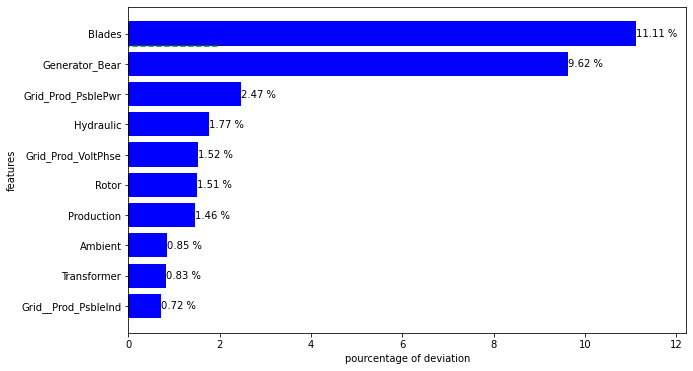

In [679]:
#f1 = pd.DataFrame(reconstructed_data[0:1], columns=my_col)
mydata2 = show_local_explaination(g3_original4.values[0],reconstructed_data3,invert_transform=False,data_train=reconstructed_data3,impact_pourcentage=10,plot=True,sort=True,show_pourcentage=True)

In [680]:
mydata2

,real_data_point,optimal_values,impact,Polarity,pourcentage_impact
Grid__Prod_PsbleInd,0.0,0.847517,0.718285,0.0,0.718285
Transformer,0.0,0.909519,0.827226,0.0,0.827226
Ambient,0.0,0.921490,0.849144,0.0,0.849144
Production,0.0,-1.209557,1.463027,-0.0,1.463027
Rotor,0.0,-1.228461,1.509116,-0.0,1.509116
Grid_Prod_VoltPhse,0.0,1.231104,1.515617,0.0,1.515617
Hydraulic,0.0,1.330725,1.770830,0.0,1.770830
Grid_Prod_PsblePwr,0.0,1.572732,2.473485,0.0,2.473485
Generator_Bear,0.0,3.101255,9.617782,0.0,9.617782
Blades,0.0,3.333258,11.110608,0.0,11.110608


In [681]:
mydata2.index[-1]

'Blades'

In [682]:
c = c-mydata2.pourcentage_impact[-1]
count =10
total_lifespan_hours = 10000
current_operating_hours = 200
temperature_factor = 0.8
error_duration_factor = count*10 
def RUL(total_lifespan_hours, current_operating_hours, temperature_factor, error_duration_factor) :
    remaing_hours =  total_lifespan_hours- (temperature_factor*error_duration_factor)- current_operating_hours 
    return remaing_hours
Rul1 =  RUL(total_lifespan_hours, current_operating_hours, temperature_factor, error_duration_factor)
Rul1 

9720.0

In [683]:
if mydata2.index[-1] in reconstructed_data3.columns or mydata2.index[-2] in g3_original4.columns  :
    print("High temperature in Transformer")
else:
    print("Checking recommended")

High temperature in Transformer


In [684]:
len(mydata.head(10).index)

10

In [685]:
def plot_Bayes_net(model):
    pos = nx.circular_layout(model)
    plt.figure(3,figsize=(12,12)) 
    #nx.draw(model, node_color='#00b4d9', pos=pos, with_labels=True)
    nx.draw_circular( model, with_labels=True, arrowsize=30, node_size=800, alpha=0.3, font_weight="bold")
    plt.show()
def compute_pourcentage(f):
    f = list(f)
    total = sum(f)
    if total != 0:
        
        result = [round((element / total) * 100) for element in f]
    else:
        # Handle the case where total is zero, for example, set all elements to a default value
        default_value = 0  # Replace this with your desired default value
        result = [default_value] * len(f)
    #result = list(map(lambda element : round(( element / total )*100) , f))
    return pd.Series(result)

In [686]:
def find_causal_graph(df_causality_matrix, col_to_inspect, method="score_based"):
    if True :
        data = df_causality_matrix[col_to_inspect]
        scoring_meth = K2Score(data=data)
        est = HillClimbSearch(data, scoring_meth)
        estimated_model = est.estimate(scoring_method=scoring_meth, max_indegree=2, max_iter=int(1e2))
        print(estimated_model)
        return estimated_model
    elif method == "constraint_based" :
        est = PC(data=df_causality_matrix[col_to_inspect])
        estimated_model = est.estimate(variant="stable", max_cond_vars=400)
        return estimated_model

In [687]:
reconstructed_data

,Timestamp,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,...,Grd_Prod_PsblePwr_Std,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg
0,2016-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-01 00:10:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-01-01 00:20:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-01-01 00:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-01-01 00:40:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52440,2016-12-31 23:10:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52441,2016-12-31 23:20:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52442,2016-12-31 23:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52443,2016-12-31 23:40:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [688]:
df_causality_matrix = reconstructed_data.copy()
df_causality_matrix.set_index('Timestamp',inplace=True)
df_causality_matrix

,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,...,Grd_Prod_PsblePwr_Std,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 00:10:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 00:20:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 00:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-01-01 00:40:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:10:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-31 23:20:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-12-31 23:30:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [689]:
df_causality_matrix.max().max()

0.0

In [690]:
df_causality_matrix[df_causality_matrix.columns] = df_causality_matrix.apply(lambda features : compute_pourcentage(features),axis=1)
df_causality_matrix = df_causality_matrix.astype(int)
df_causality_matrix

,Gen_RPM_Max,Gen_RPM_Min,Gen_RPM_Avg,Gen_RPM_Std,Gen_Bear_Temp_Avg,Gen_Phase1_Temp_Avg,Gen_Phase2_Temp_Avg,Gen_Phase3_Temp_Avg,Hyd_Oil_Temp_Avg,Gear_Oil_Temp_Avg,...,Grd_Prod_PsblePwr_Std,Grd_Prod_PsbleInd_Avg,Grd_Prod_PsbleInd_Max,Grd_Prod_PsbleInd_Min,Grd_Prod_PsbleInd_Std,Grd_Prod_PsbleCap_Avg,Grd_Prod_PsbleCap_Max,Grd_Prod_PsbleCap_Min,Grd_Prod_PsbleCap_Std,Gen_Bear2_Temp_Avg
Timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-01 00:10:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-01 00:20:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-01 00:30:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-01-01 00:40:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:10:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-12-31 23:20:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-12-31 23:30:00+00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [691]:
df_causality_matrix.reset_index(inplace=True)

In [692]:
#df_causality_matrix1 = df_causality_matrix
start_date2='2016-07-10 03:50:00'
end_date2="2016-07-10 05:40:00"
start_date2 = pd.Timestamp(start_date2)
end_date2= pd.Timestamp(end_date2)
df_causality_matrix1=df_causality_matrix[(df_causality_matrix['Timestamp'] >= start_date2) & (df_causality_matrix['Timestamp'] <= end_date2)]

TypeError: Invalid comparison between dtype=datetime64[ns, UTC] and Timestamp

In [ ]:
df_causality_matrix['HVTrafo_Phase3_Temp_Avg'].max()

0

In [ ]:
df_causality_matrix1.set_index('Timestamp',inplace=True)

In [ ]:
col_to_inspect =['Grd_Prod_Pwr_Std', 'Gen_RPM_Std', 'Blds_PitchAngle_Max', 'HVTrafo_Phase3_Temp_Avg','HVTrafo_Phase2_Temp_Avg' ]

#df_causality_matrix = compute_causality_matrix(355, test_data_mae,col_to_inspect)
causal_graph = find_causal_graph(df_causality_matrix1,col_to_inspect,method="score-based")

  0%|          | 0/100 [00:00<?, ?it/s]

DAG with 5 nodes and 0 edges


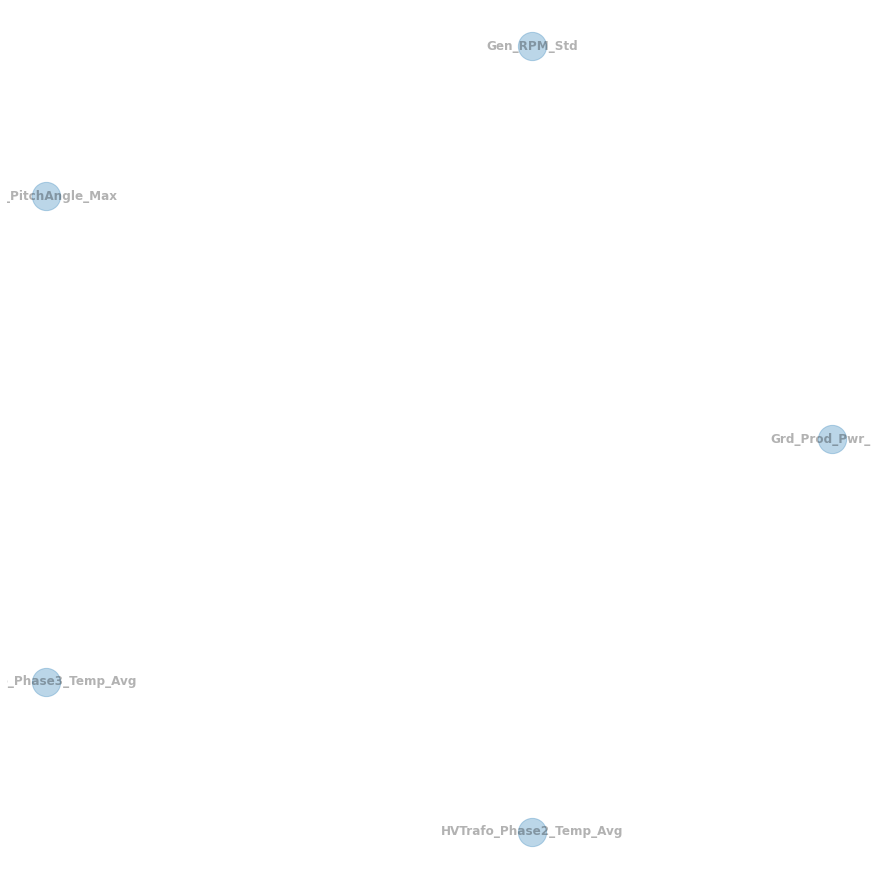

In [ ]:
plot_Bayes_net(causal_graph) #355